## Desarrollo de sistemas de aprendizaje automático para producción


Este notebook crea un [SageMaker Pipeline](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_model_building_pipeline.html) para construir un sistema de aprendizaje automático de un extremo a otro para resolver el problema de clasificar especies de pingüinos. Con SageMaker Pipeline, puede crear, automatizar y administrar flujos de trabajo de aprendizaje automático de un extremo a otro a escala.

Puede encontrar más información sobre Amazon SageMaker en la [Guía para desarrolladores de Amazon SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/whatis.html). El [Blog de AWS Machine Learning](https://aws.amazon.com/blogs/machine-learning/) es una excelente fuente para mantenerse actualizado con SageMaker.

Este ejemplo utiliza el [conjunto de datos de Penguins](https://www.kaggle.com/parulpandey/palmer-archipelago-antarctica-penguin-data), el [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html) y la biblioteca [SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/).

<img src='images/penguins.png' alt='Pingüinos' width="800">

Este cuaderno es parte del seminario  [Desarrollo de sistemas de aprendizaje automático para producción](https://www.****.******).


## Configuración inicial

:::{.callout-note}
Antes de ejecutar este cuaderno, siga las [Instrucciones de configuración](https://**.**.***/***setup.html) para el seminario.
:::

Comencemos configurando el entorno y preparándonos para ejecutar el notebook.

In [349]:
#| hide

%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv

import sys
import logging
import ipytest
import json
from pathlib import Path


CODE_FOLDER = Path("code")
CODE_FOLDER.mkdir(parents=True, exist_ok=True)
INFERENCE_CODE_FOLDER = CODE_FOLDER / "inference"
INFERENCE_CODE_FOLDER.mkdir(parents=True, exist_ok=True)

sys.path.extend([f"./{CODE_FOLDER}", f"./{INFERENCE_CODE_FOLDER}"])

DATA_FILEPATH = "penguins.csv"

ipytest.autoconfig(raise_on_error=True)

# De forma predeterminada, SageMaker SDK registra eventos relacionados con la configuración predeterminada 
# utilizando el nivel INFO. Para evitar que esto arruine el resultado de las celdas de este notebook,
# podemos cambiar el nivel de registro a ERROR.
logging.getLogger("sagemaker.config").setLevel(logging.ERROR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


Podemos ejecutar este cuaderno en [Modo local](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-local-mode.html) para probar el pipeline en tu entorno local antes de usar SageMaker.
Puedes ejecutar el código en modo local configurando la constante `LOCAL_MODE` en `True`.


In [350]:
LOCAL_MODE = False

Carguemos el nombre del bucket de S3 y el rol de AWS desde las variables de entorno:

In [351]:
import os

bucket = os.environ["BUCKET"]
role = os.environ["ROLE"]

S3_LOCATION = f"s3://{bucket}/penguins"

Si ejecuta la canalización en modo local en una máquina ARM64, necesitará utilizar una imagen de Docker personalizada para entrenar y evaluar el modelo. Esto se debe a que SageMaker no proporciona una imagen de TensorFlow que sea compatible con los chips M de Apple.

In [352]:
architecture = !(uname -m)
IS_APPLE_M_CHIP = architecture[0] == "arm64"

Creemos un diccionario de configuración con diferentes configuraciones dependiendo de si estamos ejecutando el pipeline en Modo Local o no:

In [353]:
import sagemaker
from sagemaker.workflow.pipeline_context import PipelineSession, LocalPipelineSession

pipeline_session = PipelineSession(default_bucket=bucket) if not LOCAL_MODE else None

if LOCAL_MODE:
    config = {
        "session": LocalPipelineSession(default_bucket=bucket),
        "instance_type": "local",
        # Necesitamos usar una imagen de Docker personalizada cuando ejecutamos la canalización
        # en modelo local en una máquina ARM64.
        "image": "sagemaker-tensorflow-toolkit-local" if IS_APPLE_M_CHIP else None,
    }
else:
    config = {
        "session": pipeline_session,
        "instance_type": "ml.m5.xlarge",
        "image": None,
    }

config["framework_version"] = "2.11"
config["py_version"] = "py39"

Ahora inicialicemos algunas variables que necesitaremos en todo el cuaderno:

In [354]:
import boto3

sagemaker_session = sagemaker.session.Session()
sagemaker_client = boto3.client("sagemaker")
iam_client = boto3.client("iam")
region = boto3.Session().region_name

## Clase 1 - El Machine Learning en producción es diferente

En esta sesión, ejecutaremos un análisis de datos exploratorio en el [Penguins dataset](https://www.kaggle.com/parulpandey/palmer-archipelago-antarctica-penguin-data) y construiremos un  [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) con un paso para dividir y transformar los datos.

<a href="images/training.png" target="_blank"> <img src="images/training.png" alt="Training" style="max-width: 750px;" /></a>

Usaremos un [Scikit-Learn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) para las transformaciones y un [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing) con un [SKLearnProcessor](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html#scikit-learn-processor) para ejecutar un script de preprocesamiento. Consulte la SageMaker Pipelines Overview](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) para obtener una introducción a los componentes fundamentales de SageMaker Pipeline.


### Paso 1 - Exploratory Data Analysis

Ejecutemos un análisis de datos exploratorio en el conjunto de datos. El objetivo de esta sección es comprender los datos y el problema que intentamos resolver.

Carguemos el conjunto de datos de Penguins:


In [355]:
import pandas as pd
import numpy as np

penguins = pd.read_csv(DATA_FILEPATH)
penguins.head()

species     island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen              39.1             18.7              181.0   
1  Adelie  Torgersen              39.5             17.4              186.0   
2  Adelie  Torgersen              40.3             18.0              195.0   
3  Adelie  Torgersen               NaN              NaN                NaN   
4  Adelie  Torgersen              36.7             19.3              193.0   

   body_mass_g     sex  
0       3750.0    MALE  
1       3800.0  FEMALE  
2       3250.0  FEMALE  
3          NaN     NaN  
4       3450.0  FEMALE

Podemos ver que el conjunto de datos contiene las siguientes columnas:

1. `species`: La especie de un pingüino. Esta es la columna que queremos predecir.
2. `island`: La isla donde se encontró el pingüino
3. `culmen_length_mm`: La longitud del culmen (pico) del pingüino en milímetros
4. `culmen_depth_mm`: La profundidad del culmen del pingüino en milímetros
5. `flipper_length_mm`: La longitud de la aleta del pingüino en milímetros
6. `body_mass_g`: La masa corporal del pingüino en gramos.
7. `sex`: El sexo del pingüino

Si tienes curiosidad, aquí tienes la descripción del culmen de un pingüino:

<img src='images/culmen.jpeg' alt='Culmen' width="600">

Ahora, obtengamos las estadísticas resumidas de las características de nuestro conjunto de datos.


In [356]:
penguins.describe(include="all")

species  island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
count      344     344        342.000000       342.000000         342.000000   
unique       3       3               NaN              NaN                NaN   
top     Adelie  Biscoe               NaN              NaN                NaN   
freq       152     168               NaN              NaN                NaN   
mean       NaN     NaN         43.921930        17.151170         200.915205   
std        NaN     NaN          5.459584         1.974793          14.061714   
min        NaN     NaN         32.100000        13.100000         172.000000   
25%        NaN     NaN         39.225000        15.600000         190.000000   
50%        NaN     NaN         44.450000        17.300000         197.000000   
75%        NaN     NaN         48.500000        18.700000         213.000000   
max        NaN     NaN         59.600000        21.500000         231.000000   

        body_mass_g   sex  
count    342.000000   334  
unique          NaN     3  
top             NaN  MALE  
freq            NaN   168  
mean    4201.754386   NaN  
std      801.954536   NaN  
min     2700.000000   NaN  
25%     3550.000000   NaN  
50%     4050.000000   NaN  
75%     4750.000000   NaN  
max     6300.000000   NaN

Ahora mostremos la distribución de valores para las tres columnas categóricas de nuestros datos:

In [357]:
species_distribution = penguins["species"].value_counts()
island_distribution = penguins["island"].value_counts()
sex_distribution = penguins["sex"].value_counts()

print(species_distribution)
print()
print(island_distribution)
print()
print(sex_distribution)

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

island
Biscoe       168
Dream        124
Torgersen     52
Name: count, dtype: int64

sex
MALE      168
FEMALE    165
.           1
Name: count, dtype: int64



La distribución de las categorías en nuestros datos es:

- `species`: Hay 3 especies de pingüinos en el conjunto de datos: Adelia (152), Gentoo (124) y Chinstrap (68).
- `island`: Los pingüinos son de 3 islas: Biscoe (168), Dream (124) y Torgersen (52).
- `sex`: Tenemos 168 pingüinos machos, 165 pingüinos hembras y 1 pingüino de género ambiguo (`.`).

Reemplacemos el valor ambiguo en la columna "sexo" con un valor nulo:


In [358]:
penguins["sex"] = penguins["sex"].replace(".", np.nan)
sex_distribution = penguins["sex"].value_counts()
sex_distribution

sex
MALE      168
FEMALE    165
Name: count, dtype: int64

A continuación, verifiquemos si faltan valores en el conjunto de datos.

In [359]:
penguins.isnull().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

Deshagámonos de los valores faltantes. Por ahora, reemplazaremos los valores que faltan con el valor más frecuente en la columna. Más adelante, usaremos una estrategia diferente para reemplazar los valores numéricos faltantes.

In [360]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="most_frequent")
penguins.iloc[:, :] = imputer.fit_transform(penguins)
penguins.isnull().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

Visualicemos la distribución de características categóricas.

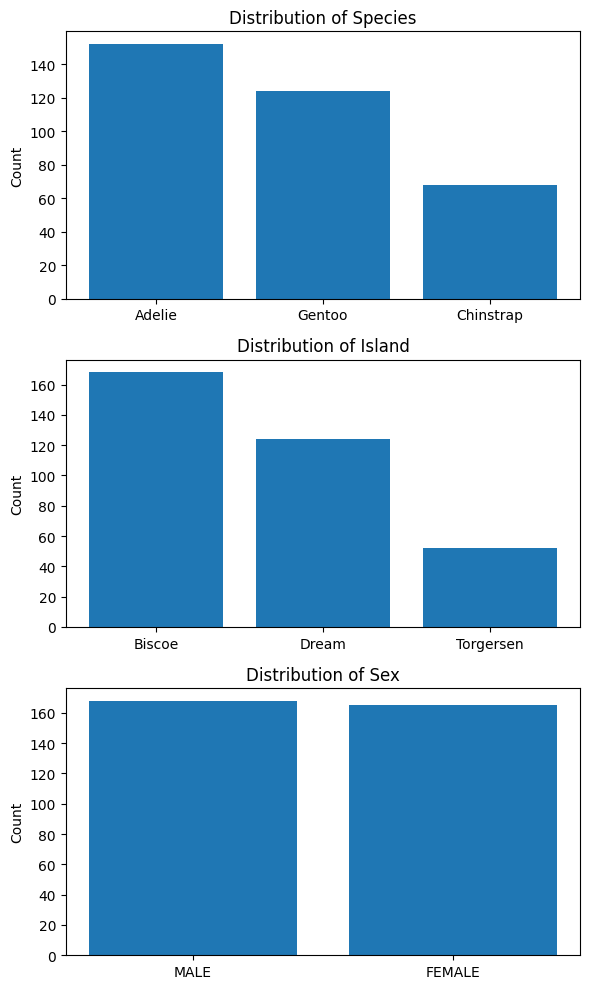

In [361]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(6, 10))

axs[0].bar(species_distribution.index, species_distribution.values)
axs[0].set_ylabel("Recuento")
axs[0].set_title("Distribución de especies")

axs[1].bar(island_distribution.index, island_distribution.values)
axs[1].set_ylabel("Recuento")
axs[1].set_title("Distribución de la isla")

axs[2].bar(sex_distribution.index, sex_distribution.values)
axs[2].set_ylabel("Recuento")
axs[2].set_title("Distribución del sexo")

plt.tight_layout()
plt.show()

Visualicemos la distribución de columnas numéricas.


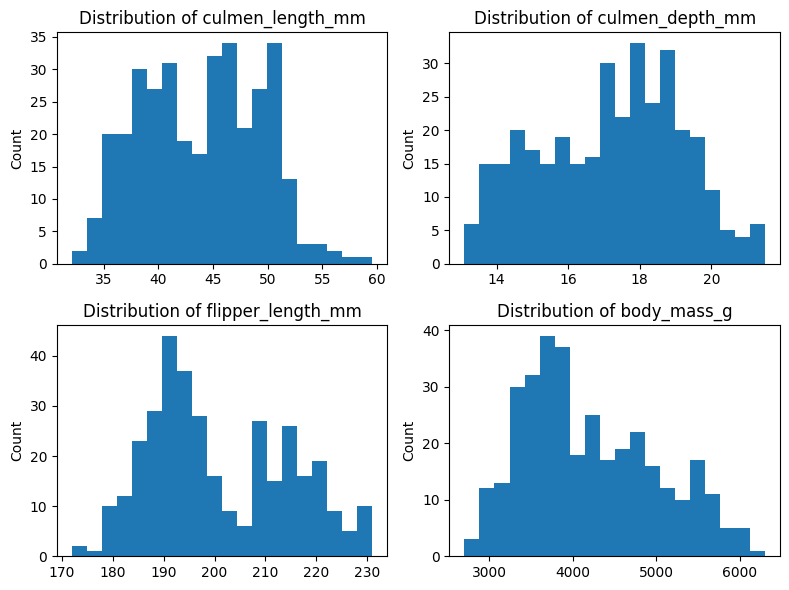

In [362]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

axs[0, 0].hist(penguins["culmen_length_mm"], bins=20)
axs[0, 0].set_ylabel("Recuento")
axs[0, 0].set_title("Distribución de culmen_length_mm")

axs[0, 1].hist(penguins["culmen_depth_mm"], bins=20)
axs[0, 1].set_ylabel("Recuento")
axs[0, 1].set_title("Distribución de  culmen_depth_mm")

axs[1, 0].hist(penguins["flipper_length_mm"], bins=20)
axs[1, 0].set_ylabel("Recuento")
axs[1, 0].set_title("Distribución de flipper_length_mm")

axs[1, 1].hist(penguins["body_mass_g"], bins=20)
axs[1, 1].set_ylabel("Recuento")
axs[1, 1].set_title("Distribución de  body_mass_g")

plt.tight_layout()
plt.show()

Mostremos la matriz de covarianza del conjunto de datos. La "covarianza" mide cómo los cambios en una variable se asocian con los cambios en una segunda variable. En otras palabras, la covarianza mide el grado en que dos variables están asociadas linealmente.

In [363]:
penguins.cov(numeric_only=True)

culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
culmen_length_mm          29.679415        -2.516984          50.260588   
culmen_depth_mm           -2.516984         3.877201         -16.108849   
flipper_length_mm         50.260588       -16.108849         197.269501   
body_mass_g             2596.971151      -742.660180        9792.552037   

                     body_mass_g  
culmen_length_mm     2596.971151  
culmen_depth_mm      -742.660180  
flipper_length_mm    9792.552037  
body_mass_g        640316.716388

Aquí hay tres ejemplos de lo que obtenemos al interpretar la siguiente matriz de covarianza:

1. Los pingüinos que pesan más tienden a tener un culmen más grande.
2. Cuanto más pesa un pingüino, menos profundo tiende a ser su culmen.
3. Existe una pequeña variación entre la profundidad del culmen de los pingüinos.

Ahora mostremos la matriz de correlación. La "correlación" mide tanto la fuerza como la dirección de la relación lineal entre dos variables.

In [364]:
penguins.corr(numeric_only=True)

culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
culmen_length_mm           1.000000        -0.234635           0.656856   
culmen_depth_mm           -0.234635         1.000000          -0.582472   
flipper_length_mm          0.656856        -0.582472           1.000000   
body_mass_g                0.595720        -0.471339           0.871302   

                   body_mass_g  
culmen_length_mm      0.595720  
culmen_depth_mm      -0.471339  
flipper_length_mm     0.871302  
body_mass_g           1.000000

Aquí hay tres ejemplos de lo que obtenemos al interpretar la matriz de correlación a continuación:

1. Los pingüinos que pesan más tienden a tener aletas más grandes.
2. Los pingüinos con un culmen menos profundo tienden a tener aletas más grandes.
3. La longitud y profundidad del culmen tienen una ligera correlación negativa.

Mostremos la distribución de especies por isla.

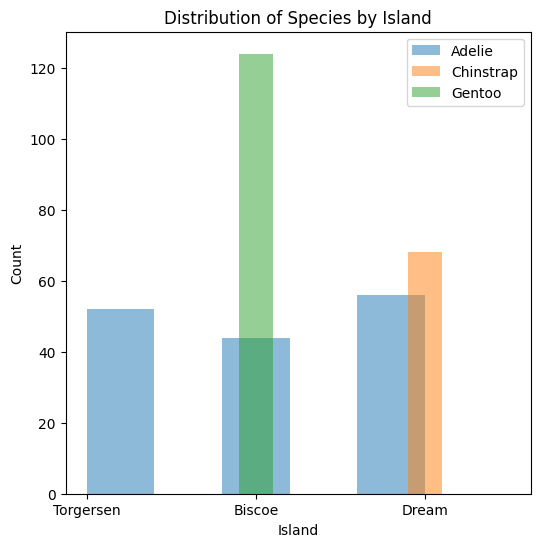

In [365]:
unique_species = penguins["species"].unique()

fig, ax = plt.subplots(figsize=(6, 6))
for species in unique_species:
    data = penguins[penguins["species"] == species]
    ax.hist(data["island"], bins=5, alpha=0.5, label=species)

ax.set_xlabel("Isla")
ax.set_ylabel("Recuento")
ax.set_title("Distribución de especies por isla")
ax.legend()
plt.show()

Let's display the distribution of species by sex.


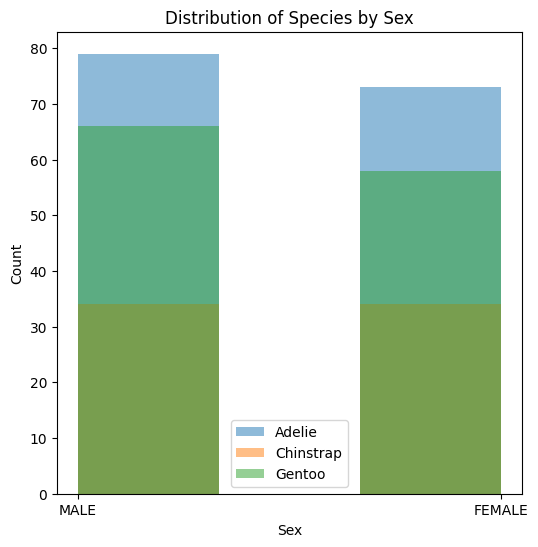

In [366]:
fig, ax = plt.subplots(figsize=(6, 6))

for species in unique_species:
    data = penguins[penguins["species"] == species]
    ax.hist(data["sex"], bins=3, alpha=0.5, label=species)

ax.set_xlabel("Sexo")
ax.set_ylabel("Recuento")
ax.set_title("Distribución de especies por sexo")

ax.legend()
plt.show()

### Paso 2 - Creating the Preprocessing Script

Aquí hay una descripción general de alto nivel del paso de preprocesamiento y el trabajo de procesamiento que SageMaker crea detrás de escena:

<a href="images/preprocess-data.png" target="_blank"> <img src="images/preprocess-data.png" alt="High-level overview of the Preprocessing Data Step and SageMaker’s Processing Jobs" style="max-width: 750px;" /></a>

El primer paso que necesitamos en el proceso es un  [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing) para que ejecute un script que dividirá y transformará los datos.  Este paso de procesamiento creará un Processing Step de SageMaker en segundo plano, ejecutará el script y cargará el resultado en S3. Puede utilizar Processing Jobs para realizar preprocesamiento de datos, posprocesamiento, ingeniería de características, validación de datos y evaluación de modelos. Consulte la documentación del SDK de [ProcessingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep)  de SageMaker para obtener más información.


El primer paso es crear el script que dividirá y transformará los datos de entrada.

In [367]:
%%writefile {CODE_FOLDER}/preprocessor.py
#| label: preprocessing-script
#| echo: true
#| output: false
#| filename: preprocessor.py
#| code-line-numbers: true

import os
import tarfile
import tempfile
import joblib
import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder


def preprocess(base_directory):
    """
    Esta función carga los datos proporcionados, los divide y los transforma.
    """

    df = _read_data_from_input_csv_files(base_directory)
    
    target_transformer = ColumnTransformer(
        transformers=[("species", OrdinalEncoder(), [0])]
    )
    
    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="mean"),
        StandardScaler()
    )

    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder()
    )
    
    features_transformer = ColumnTransformer(
        transformers=[
            ("numeric", numeric_transformer, make_column_selector(dtype_exclude="object")),
            ("categorical", categorical_transformer, ["island"]),
        ]
    )

    df_train, df_validation, df_test = _split_data(df)

    _save_baselines(base_directory, df_train, df_test)

    y_train = target_transformer.fit_transform(np.array(df_train.species.values).reshape(-1, 1))
    y_validation = target_transformer.transform(np.array(df_validation.species.values).reshape(-1, 1))
    y_test = target_transformer.transform(np.array(df_test.species.values).reshape(-1, 1))
    
    df_train = df_train.drop("species", axis=1)
    df_validation = df_validation.drop("species", axis=1)
    df_test = df_test.drop("species", axis=1)

    X_train = features_transformer.fit_transform(df_train)
    X_validation = features_transformer.transform(df_validation)
    X_test = features_transformer.transform(df_test)

    _save_splits(base_directory, X_train, y_train, X_validation, y_validation, X_test, y_test)
    _save_model(base_directory, target_transformer, features_transformer)
    

def _read_data_from_input_csv_files(base_directory):
    """
    Esta función lee todos los archivos CSV disponibles y los concatena
     en un solo dataframe.
    """

    input_directory = Path(base_directory) / "input"
    files = [file for file in input_directory.glob("*.csv")]
    
    if len(files) == 0:
        raise ValueError(f"The are no CSV files in {str(input_directory)}/")
        
    raw_data = [pd.read_csv(file) for file in files]
    df = pd.concat(raw_data)
    
    # Mezcla los datos
    return df.sample(frac=1, random_state=42)


def _split_data(df):
    """
    Divide los datos en tres conjuntos: entrenamiento, validación y prueba.
    """

    df_train, temp = train_test_split(df, test_size=0.3)
    df_validation, df_test = train_test_split(temp, test_size=0.5)

    return df_train, df_validation, df_test


def _save_baselines(base_directory, df_train, df_test):
    """
    Durante los pasos de monitoreo de calidad y datos, necesitaremos líneas de base  
    para calcular restricciones y estadísticas. Esta función guarda los datos
    no transformados en el disco para que podamos usarlos como líneas de base más adelante.
    """

    for split, data in [("train", df_train), ("test", df_test)]:
        baseline_path = Path(base_directory) / f"{split}-baseline"
        baseline_path.mkdir(parents=True, exist_ok=True)

        df = data.copy().dropna()

        # Queremos guardar el encabezado solo para la train baseline pero no para la test baseline.
        # Usaremos la test baseline para generar predicciones más adelante 
        # no podemos tener una  header line porque el modelo no podrá hacer una predicción para ella.
        header = split == "train"
        df.to_csv(baseline_path / f"{split}-baseline.csv", header=header, index=False)


def _save_splits(base_directory, X_train, y_train, X_validation, y_validation, X_test, y_test):
    """
    Esta función concatena las características transformadas y la variable de destino, y
    guarda cada uno de los conjuntos divididos en el disco.
    """

    train = np.concatenate((X_train, y_train), axis=1)
    validation = np.concatenate((X_validation, y_validation), axis=1)
    test = np.concatenate((X_test, y_test), axis=1)

    train_path = Path(base_directory) / "train"
    validation_path = Path(base_directory) / "validation"
    test_path = Path(base_directory) / "test"

    train_path.mkdir(parents=True, exist_ok=True)
    validation_path.mkdir(parents=True, exist_ok=True)
    test_path.mkdir(parents=True, exist_ok=True)

    pd.DataFrame(train).to_csv(train_path / "train.csv", header=False, index=False)
    pd.DataFrame(validation).to_csv(validation_path / "validation.csv", header=False, index=False)
    pd.DataFrame(test).to_csv(test_path / "test.csv", header=False, index=False)


def _save_model(base_directory, target_transformer, features_transformer):
    """
    Esta función crea un archivo model.tar.gz que contiene los dos pipelines.
    de transformacionesque construimos para transformar los datos.
    """

    with tempfile.TemporaryDirectory() as directory:
        joblib.dump(target_transformer, os.path.join(directory, "target.joblib"))
        joblib.dump(features_transformer, os.path.join(directory, "features.joblib"))
    
        model_path = Path(base_directory) / "model"
        model_path.mkdir(parents=True, exist_ok=True)
    
        with tarfile.open(f"{str(model_path / 'model.tar.gz')}", "w:gz") as tar:
            tar.add(os.path.join(directory, "target.joblib"), arcname="target.joblib")
            tar.add(os.path.join(directory, "features.joblib"), arcname="features.joblib")

    
if __name__ == "__main__":
    preprocess(base_directory="/opt/ml/processing")

Overwriting code/preprocessor.py


Probemos el script para asegurarnos de que todo funcione como se esperaba:

In [368]:
%%ipytest -s
#| code-fold: true
#| output: false

import os
import shutil
import tarfile
import pytest
import tempfile
import joblib
from preprocessor import preprocess


@pytest.fixture(scope="function", autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")
    
    directory = Path(directory)
    preprocess(base_directory=directory)
    
    yield directory
    
    shutil.rmtree(directory)


def test_preprocess_generates_data_splits(directory):
    output_directories = os.listdir(directory)
    
    assert "train" in output_directories
    assert "validation" in output_directories
    assert "test" in output_directories


def test_preprocess_generates_baselines(directory):
    output_directories = os.listdir(directory)

    assert "train-baseline" in output_directories
    assert "test-baseline" in output_directories


def test_preprocess_creates_two_models(directory):
    model_path = directory / "model"
    tar = tarfile.open(model_path / "model.tar.gz", "r:gz")

    assert "features.joblib" in tar.getnames()
    assert "target.joblib" in tar.getnames()


def test_splits_are_transformed(directory):
    train = pd.read_csv(directory / "train" / "train.csv", header=None)
    validation = pd.read_csv(directory / "validation" / "validation.csv", header=None)
    test = pd.read_csv(directory / "test" / "test.csv", header=None)

    # Después de transformar los datos, la cantidad de características debe ser 7:
    # * 3 - island (one-hot encoded)
    # * 1 - culmen_length_mm = 1
    # * 1 - culmen_depth_mm
    # * 1 - flipper_length_mm
    # * 1 - body_mass_g
    number_of_features = 7

    # Las divisiones transformadas deben tener una columna
    # adicional para las variables objetivo.
    assert train.shape[1] == number_of_features + 1
    assert validation.shape[1] == number_of_features + 1
    assert test.shape[1] == number_of_features + 1


def test_train_baseline_is_not_transformed(directory):
    baseline = pd.read_csv(directory / "train-baseline" / "train-baseline.csv", header=None)

    island = baseline.iloc[:, 1].unique()

    assert "Biscoe" in island
    assert "Torgersen" in island
    assert "Dream" in island


def test_test_baseline_is_not_transformed(directory):
    baseline = pd.read_csv(directory / "test-baseline" / "test-baseline.csv", header=None)

    island = baseline.iloc[:, 1].unique()

    assert "Biscoe" in island
    assert "Torgersen" in island
    assert "Dream" in island


def test_train_baseline_includes_header(directory):
    baseline = pd.read_csv(directory / "train-baseline" / "train-baseline.csv")
    assert baseline.columns[0] == "species"


def test_test_baseline_does_not_include_header(directory):
    baseline = pd.read_csv(directory / "test-baseline" / "test-baseline.csv")
    assert baseline.columns[0] != "species"

........
8 passed in 0.16s


### Paso 3 - Setting up the Processing Step

Vamos a definir ahora el [ProcessingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep) que usaremos en el proceso para ejecutar el script que dividirá y transformará los datos.

Varios pasos de SageMaker Pipeline admiten el almacenamiento en caché. Cuando se ejecuta un paso, y dependiendo de la política de almacenamiento en caché configurada, SageMaker intentará reutilizar el resultado de una ejecución anterior exitosa del mismo paso. Puede encontrar más información sobre este tema en  [Caching Pipeline Steps](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-caching.html).  Definamos una política de almacenamiento en caché que reutilizaremos en cada paso:


In [369]:
from sagemaker.workflow.steps import CacheConfig

cache_config = CacheConfig(enable_caching=True, expire_after="15d")

Podemos parametrizar un SageMaker Pipeline para hacerlo más flexible. En este caso, usaremos un parámetro para pasar la ubicación del conjunto de datos que queremos procesar. Podemos ejecutar el pipeline con los diferentes conjuntos de datos cambiando el valor de este parámetro. Para leer más sobre estos parámetros, consulte [Pipeline Parameters](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-parameters.html).


In [370]:
from sagemaker.workflow.parameters import ParameterString

dataset_location = ParameterString(
    name="dataset_location",
    default_value=f"{S3_LOCATION}/data",
)

Un procesador proporciona al paso de procesamiento información sobre el hardware y el software que SageMaker debe utilizar para iniciar el trabajo de procesamiento. Para ejecutar el script que creamos, necesitamos acceso a Scikit-Learn, para poder usar el  [SKLearnProcessor](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html#scikit-learn-processor) procesador que viene listo para usar con el SDK de Python de SageMaker.

SageMaker gestiona la infraestructura de un Processing Job. Aprovisiona recursos durante la duración del trabajo y limpia cuando se completa. La imagen del contenedor de procesamiento que SageMaker utiliza para ejecutar un trabajo de procesamiento puede ser una imagen integrada de SageMaker o una imagen personalizada.

La página [Data Processing with Framework Processors](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job-frameworks.html) analiza otros procesadores integrados que puede utilizar. La página  [Docker Registry Paths and Example Code](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html) contiene información sobre las versiones de framework disponibles para cada región.

In [371]:
#| code: true
#| output: false
from sagemaker.sklearn.processing import SKLearnProcessor

processor = SKLearnProcessor(
    base_job_name="preprocess-data",
    framework_version="1.2-1",
    # De forma predeterminada, una cuenta nueva no tiene acceso a las instancias `ml.m5.xlarge`.
    # Si aún no has solicitado un aumento de cuota, puedes utilizar otra
    # sn su lugar, escribe el tipo de instancia `ml.t3.medium`. Esto funcionará de inmediato, pero
    # el Processing Job tardará mucho más de lo que debería.
    #  Para obtener acceso a las instancias `ml.m5.xlarge` puede solicitar una cuota
    # de aumento en la sección Cuotas de servicio de su cuenta de AWS.
    instance_type=config["instance_type"],
    instance_count=1,
    role=role,
    sagemaker_session=config["session"],
)

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


Ahora definamos el paso de procesamiento que usaremos en el pipeline. Este paso requiere una lista de entradas que necesitamos en el script de preprocesamiento. En este caso, la entrada es el conjunto de datos que almacenamos en S3. También tenemos algunos resultados que queremos que SageMaker capture cuando finalice el trabajo de procesamiento.

In [372]:
# | code: true
# | output: false

from sagemaker.workflow.steps import ProcessingStep
from sagemaker.processing import ProcessingInput, ProcessingOutput


preprocessing_step = ProcessingStep(
    name="preprocess-data",
    step_args=processor.run(
        code=f"{CODE_FOLDER}/preprocessor.py",
        inputs=[
            ProcessingInput(
                source=dataset_location, destination="/opt/ml/processing/input"
            ),
        ],
        outputs=[
            ProcessingOutput(
                output_name="train",
                source="/opt/ml/processing/train",
                destination=f"{S3_LOCATION}/preprocessing/train",
            ),
            ProcessingOutput(
                output_name="validation",
                source="/opt/ml/processing/validation",
                destination=f"{S3_LOCATION}/preprocessing/validation",
            ),
            ProcessingOutput(
                output_name="test",
                source="/opt/ml/processing/test",
                destination=f"{S3_LOCATION}/preprocessing/test",
            ),
            ProcessingOutput(
                output_name="model",
                source="/opt/ml/processing/model",
                destination=f"{S3_LOCATION}/preprocessing/model",
            ),
            ProcessingOutput(
                output_name="train-baseline",
                source="/opt/ml/processing/train-baseline",
                destination=f"{S3_LOCATION}/preprocessing/train-baseline",
            ),
            ProcessingOutput(
                output_name="test-baseline",
                source="/opt/ml/processing/test-baseline",
                destination=f"{S3_LOCATION}/preprocessing/test-baseline",
            ),
        ],
    ),
    cache_config=cache_config,
)

/Users/svpino/dev/ml.school/.venv/lib/python3.9/site-packages/sagemaker/workflow/pipeline_context.py:297: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


### Paso 4 - Creating the Pipeline

Ahora podemos crear el SageMaker Pipeline y enviar su definición al servicio de SageMaker Pipelines para crear el pipeline si no existe o actualizarla si existe.

In [373]:
# | code: true
# | output: false

from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.pipeline_definition_config import PipelineDefinitionConfig

pipeline_definition_config = PipelineDefinitionConfig(use_custom_job_prefix=True)

session1_pipeline = Pipeline(
    name="session1-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session1_pipeline.upsert(role_arn=role)

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:325223348818:pipeline/session1-pipeline',
 'ResponseMetadata': {'RequestId': 'a15cc31f-a02b-413d-a68e-0354da62a899',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'a15cc31f-a02b-413d-a68e-0354da62a899',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '85',
   'date': 'Thu, 09 Nov 2023 20:32:21 GMT'},
  'RetryAttempts': 0}}

Ahora podemos iniciar el pipeline:


#| hide

<div class="alert" style="background-color:#0066cc;"><strong>Nota:</strong> 
    El <code>%%script</code> magic es una forma conveniente de evitar que el notebook ejecute una celda específica. Si desea ejecutar la celda, comente la línea que contiene el <code>%%script</code>  magic.
</div>


In [374]:
%%script false --no-raise-error
#| eval: false
#| code: true
#| output: false

session1_pipeline.start()

### Assignments

-   <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 1.1</strong></span> Para esta tarea, debes ejecutar el pipeline en tu entorno usando el modo local y luego cambiarla para que se ejecute en SageMaker. Después de completar esta tarea, deberías tener tu entorno completamente configurado y tu pipeline ejecutándose sin ningún problema. Esta tarea es fundamental para el resto del programa, así que asegurate de completarla antes de pasar a cualquier otra tarea.

-   <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 1.2</strong></span> El pipeline utiliza muestreo aleatorio para dividir el conjunto de datos. Modifica el código para utilizar muestreo estratificado en su lugar. El objetivo de esta tarea es ayudarte a familiarizarse con cómo modificar el script de preprocesamiento y volver a ejecutar el pipeline para ver los cambios en acción.

-   <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 1.3</strong></span> Podemos especificar diferentes valores de parámetros en un pipeline en el momento en que la iniciamos. En esta sesión, definimos un parámetro `dataset_location` que especifica la ubicación de los datos que queremos que procese la canalización. Para esta tarea, use ChatGPT para generar un conjunto de datos con 500 pingüinos aleatorios y almacene el archivo en S3. Luego, ejecute la canalización que apunta a `dataset_location` al nuevo conjunto de datos. Aquí tienes una explicación de cómo [ sobreescribir parámetros predeterminados durante la ejecución de un pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/run-pipeline.html#run-pipeline-parametrized). Puedes utilizar la herramienta de análisis avanzado de datos de ChatGPT para generar datos falsos. Si no tienes acceso a él, simplemente puede duplicar tu conjunto de datos y almacenalo en una ubicación de S3 diferente.

-   <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 1.4</strong></span> Para esta tarea, queremos ejecutar un Processing Job distribuido en varias instancias para poner en mayúscula la columna "island" del conjunto de datos. Su conjunto de datos constará de 10 archivos diferentes almacenados en S3. Configure un paso de procesamiento utilizando dos instancias. Al especificar la entrada para el paso de procesamiento, debe establecer el atributo  `ProcessingInput.s3_data_distribution_type` en `ShardedByS3Key`. Al hacer esto, SageMaker ejecutará un clúster con dos instancias simultáneamente, cada una con acceso a la mitad de los archivos. Consulte la documentación de [`S3DataDistributionType`](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_S3DataSource.html) para obtener más información.

-   <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 1.5</strong></span> Puedes utilizar [Amazon SageMaker Data Wrangler](https://aws.amazon.com/sagemaker/data-wrangler/) para completar cada paso del flujo de trabajo de preparación de datos (incluida la selección, limpieza, exploración, visualización y procesamiento de datos a escala) desde una única interfaz visual. Para esta tarea, cargue la interfaz Data Wrangler y úsela para construir las mismas transformaciones que implementamos usando Scikit-Learn Pipeline. Si tiene preguntas, abra el [Penguins Data Flow](penguins.flow) incluido en este repositorio.


## Clase 2 -  Construcción de modelos y proceso de entrenamiento.

Esta clase amplía el [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) que creamos en la sesión anterior con un paso para entrenar un modelo. Exploraremos el [Training Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-training) y el [Tuning Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-tuning).

<a href="images/training.png" target="_blank"> <img src="images/training.png" alt="Training" style="max-width: 750px;" /></a>

Presentaremos [Amazon SageMaker Experiments](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html) y los usaremos durante el training. Para obtener más información sobre este tema, consulte la [SageMaker Experiments' SDK documentation](https://sagemaker.readthedocs.io/en/v2.174.0/experiments/sagemaker.experiments.html).


### Paso 1 - Creating the Training Script

Aquí hay una descripción general de alto nivel del paso de capacitación y el trabajo de capacitación que SageMaker crea detrás de escena:

<a href="images/train-model.png" target="_blank"> <img src="images/train-model.png" alt="High-level overview of the Train Model Step and SageMaker's Training Jobs" style="max-width: 750px;" /></a>

El siguiente script es responsable de entrenar una red neuronal usando los datos de entrenamiento, validar el modelo y guardarlo para que podamos usarlo más tarde:

In [375]:
%%writefile {CODE_FOLDER}/train.py
#| label: training-script
#| echo: true
#| output: false
#| filename: train.py
#| code-line-numbers: true

import os
import argparse

import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD


def train(model_directory, train_path, validation_path, epochs=50, batch_size=32):
    X_train = pd.read_csv(Path(train_path) / "train.csv")
    y_train = X_train[X_train.columns[-1]]
    X_train.drop(X_train.columns[-1], axis=1, inplace=True)
    
    X_validation = pd.read_csv(Path(validation_path) / "validation.csv")
    y_validation = X_validation[X_validation.columns[-1]]
    X_validation.drop(X_validation.columns[-1], axis=1, inplace=True)
        
    model = Sequential([
        Dense(10, input_shape=(X_train.shape[1],), activation="relu"),
        Dense(8, activation="relu"),
        Dense(3, activation="softmax"),
    ])
    
    model.compile(
        optimizer=SGD(learning_rate=0.01),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    model.fit(
        X_train, 
        y_train, 
        validation_data=(X_validation, y_validation),
        epochs=epochs, 
        batch_size=batch_size,
        verbose=2,
    )

    predictions = np.argmax(model.predict(X_validation), axis=-1)
    print(f"Validation accuracy: {accuracy_score(y_validation, predictions)}")
    
    model_filepath = Path(model_directory) / "001"
    model.save(model_filepath)    
    

if __name__ == "__main__":
    # Todos los hiperparámetros proporcionados por el trabajo de entrenamiento  
    # se pasan al punto de entrada como argumentos de script.
    parser = argparse.ArgumentParser()
    parser.add_argument("--epochs", type=int, default=50)
    parser.add_argument("--batch_size", type=int, default=32)
    args, _ = parser.parse_known_args()

    train(
        # Esta es la ubicación donde necesitamos guardar nuestro modelo. 
        # SageMaker creará un archivo model.tar.gz con cualquier elemento 
        # dentro de este directorio cuando finalice el script de training
        model_directory=os.environ["SM_MODEL_DIR"],

        # SageMaker crea un canal para cada una de las entradas del
        # Training Step / Paso de entrenamiento.
        train_path=os.environ["SM_CHANNEL_TRAIN"],
        validation_path=os.environ["SM_CHANNEL_VALIDATION"],

        epochs=args.epochs,
        batch_size=args.batch_size,
    )

Overwriting code/train.py


Probemos el script para asegurarnos de que todo funcione como se esperaba:

In [376]:
%%ipytest -s
#| code-fold: true
#| output: false

import os
import shutil
import tarfile
import pytest
import tempfile
import joblib

from preprocessor import preprocess
from train import train


@pytest.fixture(scope="function", autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")
    
    directory = Path(directory)
    
    preprocess(base_directory=directory)
    train(
        model_directory=directory / "model",
        train_path=directory / "train", 
        validation_path=directory / "validation",
        epochs=1
    )
    
    yield directory
    
    shutil.rmtree(directory)


def test_train_saves_a_folder_with_model_assets(directory):
    output = os.listdir(directory / "model")
    assert "001" in output
    
    assets = os.listdir(directory / "model" / "001")
    assert "saved_model.pb" in assets

8/8 - 0s - loss: 1.0481 - accuracy: 0.3933 - val_loss: 0.9980 - val_accuracy: 0.5686 - 213ms/epoch - 27ms/step
2/2 [==============================] - 0s 1ms/step


INFO:tensorflow:Assets written to: /var/folders/4c/v1q3hy1x4mb5w0wpc72zl3_w0000gp/T/tmpwkbkm0g1/model/001/assets


Validation accuracy: 0.5686274509803921
.
1 passed in 0.49s


### Paso 2 - Setting up the Training Step

Ahora podemos crear un [Training Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-training) que podemos agregar al pipeline. Este training step creará un training job de SageMaker en segundo plano, ejecutará el script de entrenamiento y subirá la salida a S3. Consulta la documentación de SageMaker SDK sobre  [TrainingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TrainingStep) para obtener más información.

SageMaker utiliza el concepto de un [Estimator](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) para manejar los training jobs e implementación de extremo a extremo. Para este ejemplo, utilizaremos el  [TensorFlow Estimator](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html#tensorflow-estimator)  para ejecutar el script de training que escribimos anteriormente. 


SageMaker gestiona la infraestructura de un training job. Aprovisiona recursos durante la duración del job y los limpia cuando se completa. La imagen del contenedor de entrenamiento que SageMaker utiliza para ejecutar un training Job puede ser una imagen incorporada de SageMaker o una imagen personalizada.

La página [Docker Registry Paths and Example Code](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html) contiene información sobre las versiones de frameworks disponibles para cada región. Aquí, también puedes verificar las imágenes disponibles de [Deep Learning Container images](https://github.com/aws/deep-learning-containers/blob/master/available_images.md).

Observa la lista de hiperparámetros definidos a continuación. SageMaker pasará estos hiperparámetros como argumentos al punto de entrada del script de training.

Vamos a utilizar[SageMaker Experiments](https://sagemaker.readthedocs.io/en/v2.174.0/experiments/sagemaker.experiments.html) para registrar información del training job. Para obtener más información, consulta [Manage Machine Learning with Amazon SageMaker Experiments](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html). La lista de definiciones de métricas le dirá a SageMaker qué métricas seguir y cómo analizarlas a partir de los registros del Trabajo del  training Job. 


In [377]:
from sagemaker.tensorflow import TensorFlow

estimator = TensorFlow(
    base_job_name="training",
    entry_point=f"{CODE_FOLDER}/train.py",
    # SageMaker pasará estos hiperparámetros como argumentos
    # al entrypoint del training script.
    hyperparameters={
        "epochs": 50,
        "batch_size": 32,
    },
    # SageMaker realizará un seguimiento de estas métricas como parte del experimento.
    # Las definiciones de métricas le indican a SageMaker
    # cómo analizar los valores de los registros del training job.
    metric_definitions=[
        {"Name": "loss", "Regex": "loss: ([0-9\\.]+)"},
        {"Name": "accuracy", "Regex": "accuracy: ([0-9\\.]+)"},
        {"Name": "val_loss", "Regex": "val_loss: ([0-9\\.]+)"},
        {"Name": "val_accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"},
    ],
    image_uri=config["image"],
    framework_version=config["framework_version"],
    py_version=config["py_version"],
    instance_type=config["instance_type"],
    instance_count=1,
    disable_profiler=True,
    sagemaker_session=config["session"],
    role=role,
)

Ahora podemos crear un [Training Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-training). Este training step creará un training job de SageMaker en segundo plano, ejecutará el script de training y cargará el resultado en S3. Consulte la documentación del SDK de[TrainingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TrainingStep) de SageMaker para obtener más información.

Este paso recibirá el train data y la validation data dividida del paso anterior como entradas.

Aquí, utilizamos dos canales de entrada, `train` and `validation`. SageMaker creará automáticamente una variable de entorno correspondiente a cada uno de estos canales siguiendo el formato `SM_CHANNEL_[channel_name]`:

-   `SM_CHANNEL_TRAIN`: Esta variable de entorno contendrá la ruta a los datos en el canal `train`.
-   `SM_CHANNEL_VALIDATION`: Esta variable de entorno contendrá la ruta a los datos en el canal `validation`.

In [378]:
# | code: true
# | output: false

from sagemaker.workflow.steps import TrainingStep
from sagemaker.inputs import TrainingInput

train_model_step = TrainingStep(
    name="train-model",
    step_args=estimator.fit(
        inputs={
            "train": TrainingInput(
                s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "train"
                ].S3Output.S3Uri,
                content_type="text/csv",
            ),
            "validation": TrainingInput(
                s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "validation"
                ].S3Output.S3Uri,
                content_type="text/csv",
            ),
        }
    ),
    cache_config=cache_config,
)

/Users/svpino/dev/ml.school/.venv/lib/python3.9/site-packages/sagemaker/workflow/pipeline_context.py:297: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


### Paso 3 - Setting up a Tuning Step

Ahora creemos un [Tuning Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-tuning). Este paso de ajuste creará un trabajo de ajuste de hiperparámetros de SageMaker en segundo plano y utilizará el script de entrenamiento para entrenar diferentes variantes del modelo y elegir la mejor. Consulte la documentación del SDK de [TuningStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TuningStep) de SageMaker para obtener más información.

Dado que podríamos usar el training del tuning step para crear el modelo, definiremos esta constante para indicar qué enfoque queremos ejecutar. Tenga en cuenta que el tuning step no se admite en el modo local.

In [379]:
USE_TUNING_STEP = False and not LOCAL_MODE

El Tuning Step requiere una ferencia a [HyperparameterTuner](https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html) para configurar el Hyperparameter Tuning Job.

Aquí está la configuración que usaremos para encontrar el mejor modelo:

1. `objective_metric_name`: Este es el nombre de la métrica que utilizará el sintonizador para determinar el mejor modelo.
2. `objective_type`: Este es el objetivo del tuner. Especifica si debe minimizar la métrica o maximizarla. En este ejemplo, dado que utilizamos la precisión de validación del modelo, queremos que el objetivo sea "Maximizar". Si estuviéramos usando la pérdida del modelo, estableceríamos el objetivo en "Minimizar".
3. `metric_definitions`:  Define cómo el tuning determinará el valor de la métrica al observar los registros de salida del proceso de entrenamiento.

El tuner espera la lista de hiperparámetros que desea explorar. Puede utilizar subclases de la clase [Parameter](https://sagemaker.readthedocs.io/en/stable/api/training/parameter.html#sagemaker.parameter.ParameterRange) para especificar diferentes tipos de hiperparámetros. Este ejemplo explora diferentes valores para el hiperparámetro  `epochs`.

Finalmente, puede controlar la cantidad de jobs y cuántos de ellos se ejecutarán en paralelo usando los dos argumentos siguientes:

-   `max_jobs`: Define el número total máximo de trabajos de entrenamiento que se iniciarán para el trabajo de ajuste de hiperparámetros.
-   `max_parallel_jobs`: Define el número máximo de training jobs paralelos para iniciar.


In [380]:
from sagemaker.tuner import HyperparameterTuner
from sagemaker.parameter import IntegerParameter

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name="val_accuracy",
    objective_type="Maximize",
    hyperparameter_ranges={
        "epochs": IntegerParameter(10, 50),
    },
    metric_definitions=[{"Name": "val_accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"}],
    max_jobs=3,
    max_parallel_jobs=3,
)

Ahora podemos crear el Tuning Step usando el tuner que configuramos antes.

Aquí hay una descripción general de alto nivel de este paso y de Hyperparameter Tuning Job que SageMaker crea detrás de escena:

<a href="images/tune-model.png" target="_blank"> <img src="images/tune-model.png" alt="High-level overview of the Tune Model Step and SageMaker's Hyperparameter Tuning Jobs" style="max-width: 750px;" /></a>

In [381]:
from sagemaker.workflow.steps import TuningStep

tune_model_step = TuningStep(
    name="tune-model",
    step_args=tuner.fit(
        inputs={
            "train": TrainingInput(
                s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "train"
                ].S3Output.S3Uri,
                content_type="text/csv",
            ),
            "validation": TrainingInput(
                s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "validation"
                ].S3Output.S3Uri,
                content_type="text/csv",
            ),
        },
    ),
    cache_config=cache_config,
)

### Paso 4 - Creating the Pipeline

Definamos el SageMaker Pipeline y enviemos su definición al servicio SageMaker Pipelines para crear el pipeline si no existe o actualizarla si existe.

In [382]:
# | code: true
# | output: false

session2_pipeline = Pipeline(
    name="session2-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
        tune_model_step if USE_TUNING_STEP else train_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session2_pipeline.upsert(role_arn=role)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:325223348818:pipeline/session2-pipeline',
 'ResponseMetadata': {'RequestId': 'ad240be3-0c80-49ec-b17a-4e891f46d30b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'ad240be3-0c80-49ec-b17a-4e891f46d30b',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '85',
   'date': 'Thu, 09 Nov 2023 20:32:23 GMT'},
  'RetryAttempts': 0}}

Ahora podemos iniciar la canalización:

#| hide

<div class="alert" style="background-color:#0066cc;"><strong>Nota:</strong> 
    El <code>%%script</code> magic es una forma conveniente de evitar que el notebook ejecute una celda específica. Si desea ejecutar la celda, comente la línea que contiene el <code>%%script</code>  magic.
</div>


In [383]:
%%script false --no-raise-error
#| eval: false
#| code: true
#| output: false

session2_pipeline.start()

### Assignments

-   <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 2.1</strong></span> El script de entrenamiento entrena el modelo utilizando un valor de tasa de aprendizaje hard-coded. Modifique el script para aceptar la tasa de aprendizaje como un parámetro que podemos pasar desde el pipeline.

-   <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 2.2</strong></span> Actualmente definimos el número de epochs para entrenar el modelo como una constante que pasamos al Estimator usando la lista de hiperparámetros. Reemplace esta constante con un nuevo parámetro de canalización llamado `training_epochs`.

-   <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 2.3</strong></span> El proceso de tuning actual tiene como objetivo encontrar el modelo con la mayor precisión de validación. Modifique el código para que el mejor modelo sea el que tenga la menor pérdida de entrenamiento.

-   <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 2.4</strong></span> Usamos una instancia de [`SKLearnProcessor`](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html#scikit-learn-processor) para ejecutar el script que transforma y divide el datos. Si bien este procesador es conveniente, no nos permite instalar bibliotecas adicionales en el contenedor. Modifique el código para usar una instancia de [`FrameworkProcessor`](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.processing.FrameworkProcessor)  en lugar de  `SKLearnProcessor`. Esta clase nos permitirá especificar un directorio que contenga un archivo `requirements.txt` que contenga cualquier dependencia adicional. SageMaker instalará estas bibliotecas en el contenedor de procesamiento antes de activar el trabajo de procesamiento.

-   <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 2.5</strong></span> Configuramos el training step para registrar información del training job como parte del experimento de SageMaker asociado al pipeline. Como parte de esta tarea, consulte  [Manage Machine Learning with Amazon SageMaker Experiments](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html) y explore los experimentos generados en SageMaker Studio Console, para que puedas familiarizarse con la información que SageMaker registra durante el entrenamiento.

## Clase 3 - Evaluación y versionamiento de modelos

Esta sesión amplía [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) con un paso para evaluar el modelo y registrarlo si alcanza un umbral de precisión predefinido. 

<a href="images/training.png" target="_blank"> <img src="images/training.png" alt="Training" style="max-width: 750px;" /></a>

Usaremos un [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing) para ejecutar un script de evaluación. Usaremos un [Condition Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-condition) para determinar si la precisión del modelo está por encima de un umbral y un  [Model Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-model)  para registrar el modelo en el [SageMaker Model Registry](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry.html).


### Paso 1 - Creando un script de evaluación

Aquí hay una descripción general de alto nivel del paso de evaluación y el trabajo de procesamiento que SageMaker crea detrás de escena:

<a href="images/evaluate-model.png" target="_blank"> <img src="images/evaluate-model.png" alt="High-level overview of the Evaluate Model Step and SageMaker's Processing Jobs" style="max-width: 750px;" /></a>

Creemos el script de evaluación. El Processing Step iniciará un Processing Job y ejecutará este script dentro de un contenedor. Este script es responsable de cargar el modelo que creamos y evaluarlo en el conjunto de prueba. Antes de finalizar, este script generará un informe de evaluación del modelo.

In [384]:
%%writefile {CODE_FOLDER}/evaluation.py
#| label: evaluation-script
#| echo: true
#| output: false
#| filename: evaluation.py
#| code-line-numbers: true

import json
import tarfile
import numpy as np
import pandas as pd

from pathlib import Path
from tensorflow import keras
from sklearn.metrics import accuracy_score


def evaluate(model_path, test_path, output_path):
    X_test = pd.read_csv(Path(test_path) / "test.csv")
    y_test = X_test[X_test.columns[-1]]
    X_test.drop(X_test.columns[-1], axis=1, inplace=True)

    # Ahora extraigamos el model package para poder cargarlo
    # en la memoria.
    with tarfile.open(Path(model_path) / "model.tar.gz") as tar:
        tar.extractall(path=Path(model_path))
        
    model = keras.models.load_model(Path(model_path) / "001")
    
    predictions = np.argmax(model.predict(X_test), axis=-1)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Test accuracy: {accuracy}")

    # Creemos un informe de evaluación utilizando la precisión del modelo..
    evaluation_report = {
        "metrics": {
            "accuracy": {
                "value": accuracy
            },
        },
    }
    
    Path(output_path).mkdir(parents=True, exist_ok=True)
    with open(Path(output_path) / "evaluation.json", "w") as f:
        f.write(json.dumps(evaluation_report))
        
        
if __name__ == "__main__":
    evaluate(
        model_path="/opt/ml/processing/model/", 
        test_path="/opt/ml/processing/test/",
        output_path="/opt/ml/processing/evaluation/"
    )

Overwriting code/evaluation.py


Probemos el script para asegurarnos de que todo funcione como se esperaba:

In [385]:
%%ipytest -s
#| code-fold: true
#| output: false

import os
import shutil
import tarfile
import pytest
import tempfile
import joblib

from preprocessor import preprocess
from train import train
from evaluation import evaluate


@pytest.fixture(scope="function", autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")
    
    directory = Path(directory)
    
    preprocess(base_directory=directory)
    
    train(
        model_directory=directory / "model",
        train_path=directory / "train", 
        validation_path=directory / "validation",
        epochs=1
    )
    
    # Después de entrenar un modelo, necesitamos preparar un paquete como
    # SageMaker lo haría. Este paquete es lo que el script de evaluación 
    # espera como entrada.
    with tarfile.open(directory / "model.tar.gz", "w:gz") as tar:
        tar.add(directory / "model" / "001", arcname="001")
        
    evaluate(
        model_path=directory, 
        test_path=directory / "test",
        output_path=directory / "evaluation",
    )

    yield directory / "evaluation"
    
    shutil.rmtree(directory)


def test_evaluate_generates_evaluation_report(directory):
    output = os.listdir(directory)
    assert "evaluation.json" in output


def test_evaluation_report_contains_accuracy(directory):
    with open(directory / "evaluation.json", 'r') as file:
        report = json.load(file)
        
    assert "metrics" in report
    assert "accuracy" in report["metrics"]
    

8/8 - 0s - loss: 1.0397 - accuracy: 0.1674 - val_loss: 1.0632 - val_accuracy: 0.2157 - 207ms/epoch - 26ms/step
2/2 [==============================] - 0s 2ms/step


INFO:tensorflow:Assets written to: /var/folders/4c/v1q3hy1x4mb5w0wpc72zl3_w0000gp/T/tmpf7nrbyjs/model/001/assets


Validation accuracy: 0.21568627450980393


2/2 [==============================] - 0s 1ms/step
Test accuracy: 0.21568627450980393
.

8/8 - 0s - loss: 0.8965 - accuracy: 0.8661 - val_loss: 0.8945 - val_accuracy: 0.8431 - 219ms/epoch - 27ms/step
2/2 [==============================] - 0s 2ms/step
Validation accuracy: 0.8431372549019608


INFO:tensorflow:Assets written to: /var/folders/4c/v1q3hy1x4mb5w0wpc72zl3_w0000gp/T/tmpsk_xqtve/model/001/assets


2/2 [==============================] - 0s 1ms/step
Test accuracy: 0.8431372549019608
.
2 passed in 1.23s


### Paso 2: Configuración del paso de evaluación

Para ejecutar el script de evaluación, usaremos un [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing) configurado con [TensorFlowProcessor](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job-frameworks-tensorflow.html) porque el script necesita acceso a TensorFlow.

In [386]:
# | code: true
# | output: false

from sagemaker.tensorflow import TensorFlowProcessor

evaluation_processor = TensorFlowProcessor(
    base_job_name="evaluation-processor",
    image_uri=config["image"],
    framework_version=config["framework_version"],
    py_version=config["py_version"],
    instance_type=config["instance_type"],
    instance_count=1,
    role=role,
    sagemaker_session=config["session"],
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Uno de las entradas al Evaluation Step serán los assets del modelo. Podemos usar el indicador `USE_TUNING_STEP` para determinar si creamos el modelo usando un Training Step o un Tuning Step. En caso de que estemos usando el  Tuning Step, podemos usar [TuningStep.get_top_model_s3_uri()](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TuningStep.get_top_model_s3_uri) para obtener los assets del modelo del  training job de mayor rendimiento del Hyperparameter Tuning Job.


In [387]:
model_assets = train_model_step.properties.ModelArtifacts.S3ModelArtifacts

if USE_TUNING_STEP:
    model_assets = tune_model_step.get_top_model_s3_uri(
        top_k=0, s3_bucket=config["session"].default_bucket()
    )

SageMaker admite la asignación de salidas a archivos de propiedades. Esto es útil cuando se accede a una propiedad específica desde la canalización. En nuestro caso, queremos acceder a la precisión del modelo en el paso de condición, por lo que asignaremos el informe de evaluación a un archivo de propiedad. Consulte [How to Build and Manage Property Files](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-propertyfile.html) para obtener más información.


In [388]:
from sagemaker.workflow.properties import PropertyFile

evaluation_report = PropertyFile(
    name="evaluation-report", output_name="evaluation", path="evaluation.json"
)

We are now ready to define the [ProcessingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep) that will run the evaluation script:

In [389]:
# | code: true
# | output: false

evaluate_model_step = ProcessingStep(
    name="evaluate-model",
    step_args=evaluation_processor.run(
        inputs=[
            # La primera entrada es la división de prueba que generamos en
            # el primer paso del proceso cuando dividimos 
            # y transformamos los datos.
            ProcessingInput(
                source=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "test"
                ].S3Output.S3Uri,
                destination="/opt/ml/processing/test",
            ),
            # La segunda entrada es el modelo que generamos en 
            # el Training o Tunning Step.
            ProcessingInput(
                source=model_assets,
                destination="/opt/ml/processing/model",
            ),
        ],
        outputs=[
            # El resultado es el informe de evaluación que 
            # generamos en el script de evaluación.
            ProcessingOutput(
                output_name="evaluation", source="/opt/ml/processing/evaluation"
            ),
        ],
        code=f"{CODE_FOLDER}/evaluation.py",
    ),
    property_files=[evaluation_report],
    cache_config=cache_config,
)

/Users/svpino/dev/ml.school/.venv/lib/python3.9/site-packages/sagemaker/workflow/pipeline_context.py:297: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


### Paso 3: registrar el modelo

Ahora creemos una nueva versión del modelo y registrémoslo en el Model Registry. Consulte  [Register a Model Version](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry-version.html) para obtener más información sobre el registro de modelos.

A continuación se ofrece una descripción general de alto nivel de cómo registrar un modelo en el Registro de modelos:

<a href="images/registration-step.png" target="_blank"> <img src="images/registration-step.png" alt="High-level overview of the registering a model using the SageMaker's Model Step" style="max-width: 750px;" /></a>


Primero, definamos el nombre del grupo donde registraremos el modelo:

In [390]:
MODEL_PACKAGE_GROUP = "penguins"

Ahora creemos el modelo que registraremos en el Registro de Modelos. El modelo que entrenamos usa TensorFlow, por lo que podemos usar la clase incorporada [TensorFlowModel](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html#tensorflow-serving-model) para crear una instancia del modelo:


In [391]:
from sagemaker.tensorflow.model import TensorFlowModel

tensorflow_model = TensorFlowModel(
    model_data=model_assets,
    framework_version=config["framework_version"],
    sagemaker_session=config["session"],
    role=role,
)

Cuando registramos un modelo en el Model Registry, podemos adjuntarle metadatos relevantes. Usaremos el informe de evaluación que generamos durante el Evaluation Step para completar las  [metrics](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_metrics.ModelMetrics) de este modelo:


In [392]:
from sagemaker.model_metrics import ModelMetrics, MetricsSource
from sagemaker.workflow.functions import Join

model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri=Join(
            on="/",
            values=[
                evaluate_model_step.properties.ProcessingOutputConfig.Outputs[
                    "evaluation"
                ].S3Output.S3Uri,
                "evaluation.json",
            ],
        ),
        content_type="application/json",
    )
)

Podemos utilizar un [Model Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-model) para registrar el modelo. Consulte la documentación del SDK de [ModelStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.model_step.ModelStep) de SageMaker para obtener más información.

In [393]:
# | code: true
# | output: false

from sagemaker.workflow.model_step import ModelStep

register_model_step = ModelStep(
    name="register-model",
    step_args=tensorflow_model.register(
        model_package_group_name=MODEL_PACKAGE_GROUP,
        approval_status="Approved",
        model_metrics=model_metrics,
        content_types=["text/csv"],
        response_types=["application/json"],
        inference_instances=[config["instance_type"]],
        transform_instances=[config["instance_type"]],
        domain="MACHINE_LEARNING",
        task="CLASSIFICATION",
        framework="TENSORFLOW",
        framework_version=config["framework_version"],
    ),
)

INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


### Paso 4 - Configuración de un Condition Step

Solo queremos registrar un nuevo modelo si su precisión excede un umbral predefinido. Podemos usar un [Condition Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-condition) junto con el informe de evaluación que generamos. para lograr esto.

Aquí hay una descripción general de alto nivel del paso de condición:

<a href="images/condition-step.png" target="_blank"> <img src="images/condition-step.png" alt="High-level overview of the Condition Step" style="max-width: 750px;" /></a>

Definamos un nuevo [Pipeline Parameter](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-parameters.html) para especificar la precisión mínima que debe alcanzar el modelo para que estar registrado.


In [394]:
from sagemaker.workflow.parameters import ParameterFloat

accuracy_threshold = ParameterFloat(name="accuracy_threshold", default_value=0.70)

Si la precisión del modelo no es mayor o igual a nuestro umbral, enviaremos el pipeline a un [Fail Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-fail) con el mensaje de error correspondiente. Consulte la documentación del SDK de [FailStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.fail_step.FailStep) de SageMaker para obtener más información.


In [395]:
from sagemaker.workflow.fail_step import FailStep

fail_step = FailStep(
    name="fail",
    error_message=Join(
        on=" ",
        values=[
            "Execution failed because the model's accuracy was lower than",
            accuracy_threshold,
        ],
    ),
)

Podemos usar una condición [ConditionGreaterThanOrEqualTo](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.conditions.ConditionGreaterThanOrEqualTo) para comparar la precisión del modelo con la límite. Consulte la sección [Conditions](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_model_building_pipeline.html#conditions) en la documentación para obtener más información sobre los tipos de condiciones admitidas.


In [396]:
from sagemaker.workflow.functions import JsonGet
from sagemaker.workflow.conditions import ConditionGreaterThanOrEqualTo

condition = ConditionGreaterThanOrEqualTo(
    left=JsonGet(
        step_name=evaluate_model_step.name,
        property_file=evaluation_report,
        json_path="metrics.accuracy.value",
    ),
    right=accuracy_threshold,
)

Ahora definamos el paso de condición:

In [397]:
from sagemaker.workflow.condition_step import ConditionStep

condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition],
    if_steps=[register_model_step] if not LOCAL_MODE else [],
    else_steps=[fail_step],
)

### Paso 5 - Creación del pipeline

Ahora podemos definir SageMaker Pipeline y enviar su definición al servicio SageMaker Pipelines para crear la canalización si no existe o actualizarla si existe.

In [398]:
# | code: true
# | output: false

session3_pipeline = Pipeline(
    name="session3-pipeline",
    parameters=[dataset_location, accuracy_threshold],
    steps=[
        preprocessing_step,
        tune_model_step if USE_TUNING_STEP else train_model_step,
        evaluate_model_step,
        condition_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session3_pipeline.upsert(role_arn=role)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource
Using provided s3_resource


INFO:sagemaker.processing:Uploaded None to s3://mlschool/session3-pipeline/code/998d594dff31f9c79ccb20373bc59f36/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://mlschool/session3-pipeline/code/2c207c809cb0e0e9a1d77e5247f961f9/runproc.sh
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource
Using provided s3_resource


INFO:sagemaker.processing:Uploaded None to s3://mlschool/session3-pipeline/code/998d594dff31f9c79ccb20373bc59f36/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://mlschool/session3-pipeline/code/2c207c809cb0e0e9a1d77e5247f961f9/runproc.sh


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:325223348818:pipeline/session3-pipeline',
 'ResponseMetadata': {'RequestId': '049f06de-0743-4181-af1f-411ff67ddffa',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '049f06de-0743-4181-af1f-411ff67ddffa',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '85',
   'date': 'Thu, 09 Nov 2023 20:32:28 GMT'},
  'RetryAttempts': 0}}

Ahora podemos iniciar el pipeline:

#| hide

<div class="alert" style="background-color:#0066cc;"><strong>Nota:</strong> 
    El <code>%%script</code> magic es una forma conveniente de evitar que el notebook ejecute una celda específica. Si desea ejecutar la celda, comente la línea que contiene el <code>%%script</code>  magic.
</div>


In [399]:
%%script false --no-raise-error
#| eval: false
#| code: true
#| output: false

session3_pipeline.start()

### Assignments

-   <span style="padding:4px; line-height:30px; background-color: #f2a68a; color: #000;"><strong>Assignment 3.1</strong></span> El script de evaluación calcula la precisión de el modelo y lo exporta como parte del informe de evaluación. Ampliar el informe de evaluación añadiendo la precisión y el recall del modelo en cada una de las clases.

-   <span style="padding:4px; line-height:30px; background-color: #f2a68a; color: #000;"><strong>Assignment 3.2</strong></span> Ampliar el script de evaluación para probar el modelo en cada isla por separado. El informe de evaluación debe contener la precisión del modelo en cada isla y la precisión general.

-   <span style="padding:4px; line-height:30px; background-color: #f2a68a; color: #000;"><strong>Assignment 3.3</strong></span> El Condition Step utiliza una valor de umbral hard-coded para determinar si la precisión del modelo es lo suficientemente buena para continuar. Modifique el código para que el pipeline utilice la precisión de la última versión del modelo registrado como umbral. Queremos registrar una nueva versión del modelo solo si su rendimiento es mejor que la versión anterior que registramos.

-   <span style="padding:4px; line-height:30px; background-color: #f2a68a; color: #000;"><strong>Assignment 3.4</strong></span>  El proceso actual utiliza un Training Step o un Tuning Step para construir un modelo. Modifica el pipeline para utilizar ambos pasos al mismo tiempo. El script de evaluación debe evaluar el modelo proveniente del Training Step y el mejor modelo proveniente del  Tuning Step  y generar la precisión y ubicación en S3 del mejor modelo. Debe modificar el código para registrar los assets del modelo especificados en el informe de evaluación.

-   <span style="padding:4px; line-height:30px; background-color: #f2a68a; color: #000;"><strong>Assignment 3.5</strong></span> Los pasos del pipeline pueden encontrar excepciones. En algunos casos, volver a intentarlo puede resolver estos problemas. Para esta asignación, configure el Processing Step para que reintente automáticamente el paso un máximo de 5 veces si encuentra un "InternalServerError". Consulte la documentación [Retry Policy for Pipeline Steps](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-retry-policy.html) para obtener más información.

## Clase 4 - Implementación de modelos y entrega de predicciones

En esta clase, exploraremos cómo implementar un modelo en un endpoint de SageMaker y cómo usar un pipeline de inferencia de SageMaker para controlar los datos que entran y salen del endpoint.

<a href="images/deployment.png" target="_blank"> <img src="images/deployment.png" alt="Deployment" style="max-width: 750px;" /></a>

Comencemos definiendo el nombre del endpoint donde implementaremos el modelo y creando una constante que apunte a la ubicación donde almacenaremos los datos que capturará el endpoint:

In [400]:
from sagemaker.predictor import Predictor

ENDPOINT = "penguins-endpoint"
DATA_CAPTURE_DESTINATION = f"{S3_LOCATION}/monitoring/data-capture"

### Paso 1 - Implementación del modelo desde el registro

Implementemos manualmente el último modelo desde el Model Registry en un endpoint.

Queremos consultar la lista de modelos aprobados del Model Registry y obtener el último:

In [401]:
response = sagemaker_client.list_model_packages(
    ModelPackageGroupName=MODEL_PACKAGE_GROUP,
    ModelApprovalStatus="Approved",
    SortBy="CreationTime",
    MaxResults=1,
)

package = (
    response["ModelPackageSummaryList"][0]
    if response["ModelPackageSummaryList"]
    else None
)
package

{'ModelPackageGroupName': 'penguins',
 'ModelPackageVersion': 77,
 'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:325223348818:model-package/penguins/77',
 'CreationTime': datetime.datetime(2023, 11, 3, 11, 30, 21, 903000, tzinfo=tzlocal()),
 'ModelPackageStatus': 'Completed',
 'ModelApprovalStatus': 'Approved'}

Ahora podemos crear un [Model Package](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html#sagemaker.model.ModelPackage) using the ARN of the model from the Model Registry:


In [402]:
from sagemaker import ModelPackage

if package:
    model_package = ModelPackage(
        model_package_arn=package["ModelPackageArn"],
        sagemaker_session=sagemaker_session,
        role=role,
    )

Ahora implementemos el modelo en un endpoint.

A continuación se ofrece una descripción general de los tres componentes de un Endpoint:

<a href="images/endpoint-components.png" target="_blank"> <img src="images/endpoint-components.png" alt="An overview of the three components of an Endpoint" style="max-width: 750px;" /></a>

#| hide

<div class="alert" style="background-color:#0066cc;"><strong>Nota:</strong> 
    El <code>%%script</code> magic es una forma conveniente de evitar que el notebook ejecute una celda específica. Si desea ejecutar la celda, comente la línea que contiene el <code>%%script</code>  magic.
</div>


In [403]:
%%script false --no-raise-error
#| eval: false

model_package.deploy(
    endpoint_name=ENDPOINT, 
    initial_instance_count=1, 
    instance_type=config["instance_type"]
)

Después de implementar el modelo, podemos probar el endpoint para asegurarnos de que funcione.

Cada línea del payload que enviaremos al endpoint contiene la información de un pingüino. Observe que el modelo espera datos que ya están transformados. No podemos proporcionar los datos originales de nuestro conjunto de datos porque el modelo que registramos no funcionará con él.

El punto final devolverá las predicciones para cada una de estas líneas.


In [404]:
payload = """
0.6569590202313976,-1.0813829646495108,1.2097102831892812,0.9226343641317372,1.0,0.0,0.0
-0.7751048801481084,0.8822689351285553,-1.2168066120762704,0.9226343641317372,0.0,1.0,0.0
-0.837387834894918,0.3386660813829646,-0.26237731892812,-1.92351941317372,0.0,0.0,1.0
"""

Enviemos el payload al endpoint e imprimamos su respuesta:

In [405]:
predictor = Predictor(endpoint_name=ENDPOINT)

try:
    response = predictor.predict(payload, initial_args={"ContentType": "text/csv"})
    response = json.loads(response.decode("utf-8"))

    print(json.dumps(response, indent=2))
    print(f"\nSpecies: {np.argmax(response['predictions'], axis=1)}")
except Exception as e:
    print(e)

An error occurred (ValidationError) when calling the InvokeEndpoint operation: Endpoint penguins-endpoint of account 325223348818 not found.


Después de probar el endpoint, debemos asegurarnos de eliminarlo:

#| hide

<div class="alert" style="background-color:#0066cc;"><strong>Nota:</strong> 
    El <code>%%script</code> magic es una forma conveniente de evitar que el notebook ejecute una celda específica. Si desea ejecutar la celda, comente la línea que contiene el <code>%%script</code>  magic.
</div>


In [406]:
%%script false --no-raise-error
#| eval: false
#| code: true
#| output: false

predictor.delete_endpoint()

Implementar el modelo que entrenamos directamente en un endpoint no nos permite controlar los datos que entran y salen del endpoint. El modelo de TensorFlow que entrenamos requiere datos transformados, lo que lo hace inútil para otras aplicaciones:

<a href="images/prediction-service.png" target="_blank"> <img src="images/prediction-service.png" alt="Prediction service" style="max-width: 750px;" /></a>

Afortunadamente, podemos crear un pipeline de inferencia usando SageMaker para controlar los datos que entran y salen del endpoint.

Nuestro pipeline de inferencia tendrá tres componentes:

1. Un transformador de preprocesamiento que transformará los datos de entrada al formato que espera el modelo.
2. El modelo TensorFlow que entrenamos.
3. Un transformador de posprocesamiento que transformará la salida del modelo a un formato legible por humanos.

<a href="images/inference-pipeline.png" target="_blank"> <img src="images/inference-pipeline.png" alt="Inference pipeline" style="max-width: 750px;" /></a>

Queremos que nuestro endpoint maneje datos no procesados en formato CSV y JSON y devuelva la especie del pingüino. A continuación se muestra un ejemplo del payload que queremos que admita el punto final::

```{json}
{
    "island": "Biscoe",
    "culmen_length_mm": 48.6,
    "culmen_depth_mm": 16.0,
    "flipper_length_mm": 230.0,
    "body_mass_g": 5800.0,
}
```

Y aquí hay un ejemplo del resultado que nos gustaría obtener del endpoint:

```{json}
{
    "prediction": "Adelie",
    "confidence": 0.802672
}
```


### Paso 2 - Creación del script de preprocesamiento

El primer componente de nuestro proceso de inferencia transformará los datos de entrada al formato que espera el modelo. Usaremos el transformador de Scikit-Learn que guardamos cuando dividimos y transformamos los datos. Para implementar este componente como parte de un pipeline de inferencia, necesitamos escribir un script que cargue el transformador, lo use para modificar los datos de entrada y devuelva la salida en el formato que espera el modelo de TensorFlow.


In [407]:
%%writefile {INFERENCE_CODE_FOLDER}/preprocessing_component.py
#| label: preprocessing-component
#| echo: true
#| output: false
#| filename: preprocessing_component.py
#| code-line-numbers: true

import os
import pandas as pd
import json
import joblib

from io import StringIO

try:
    from sagemaker_containers.beta.framework import encoders, worker
except ImportError:
    # No tenemos acceso a la instancia `worker` cuando realizamos pruebas localmente.
    # o configuraremos en None para que podamoscambiar la forma en que las funciones
    # crean una respuesta.
    worker = None


TARGET_COLUMN = "species"
FEATURE_COLUMNS = [
    "island",
    "culmen_length_mm",
    "culmen_depth_mm",
    "flipper_length_mm",
    "body_mass_g",
    "sex",
]


def model_fn(model_dir):
    """
    Deserializa el modelo que se utilizará en este contenedor.
    """

    return joblib.load(os.path.join(model_dir, "features.joblib"))
    

def input_fn(input_data, content_type):
    """
    Parseamos el payload de entrada y creamos un Pandas DataFrame.

    Esta función comprobará si la columna de destino está presente en los
    datos de entrada y los eliminará.
    """

    if content_type == "text/csv":
        df = pd.read_csv(StringIO(input_data), header=None, skipinitialspace=True)

        if len(df.columns) == len(FEATURE_COLUMNS) + 1:
            df = df.drop(df.columns[0], axis=1)

        df.columns = FEATURE_COLUMNS
        return df

    if content_type == "application/json":
        df = pd.DataFrame([json.loads(input_data)])

        if "species" in df.columns:
            df = df.drop("species", axis=1)

        return df

    raise ValueError(f"{content_type} is not supported!")


def predict_fn(input_data, model):
    """
    PPreprocesar la entrada utilizando el transformador.
    """

    try:
        response = model.transform(input_data)
        return response
    except ValueError as e:
        print("Error transforming the input data", e)
        return None


def output_fn(prediction, accept):
    """
    Formatea la salida de la predicción para generar una respuesta.

    El tipo de contenido/aceptación predeterminado entre contenedores para inferencia serial
    es JSON. Dado que este modelo precederá a un modelo de TensorFlow, queremos
    que devuelva un objeto JSON siguiendo los requisitos de entrada de TensorFlow.
    """

    if prediction is None:
        raise Exception("There was an error transforming the input data")

    instances = [p for p in prediction.tolist()]
    response = {"instances": instances}
    return (
        worker.Response(json.dumps(response), mimetype=accept)
        if worker
        else (response, accept)
    )

    raise Exception(f"{accept} accept type is not supported.")

Overwriting code/inference/preprocessing_component.py


Probemos el script para asegurarnos de que todo funcione como se esperaba:


In [408]:
%%ipytest
#| code-fold: true
#| output: false

from preprocessing_component import input_fn, predict_fn, output_fn, model_fn


@pytest.fixture(scope="function", autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")
    
    directory = Path(directory)
    
    preprocess(base_directory=directory)
    
    with tarfile.open(directory / "model" / "model.tar.gz") as tar:
        tar.extractall(path=directory / "model")
    
    yield directory / "model"
    
    shutil.rmtree(directory)



def test_input_csv_drops_target_column_if_present():
    input_data = """
    Adelie, Torgersen, 39.1, 18.7, 181, 3750, MALE
    """
    
    df = input_fn(input_data, "text/csv")
    assert len(df.columns) == 6 and "species" not in df.columns


def test_input_json_drops_target_column_if_present():
    input_data = json.dumps({
        "species": "Adelie", 
        "island": "Torgersen",
        "culmen_length_mm": 44.1,
        "culmen_depth_mm": 18.0,
        "flipper_length_mm": 210.0,
        "body_mass_g": 4000.0,
        "sex": "MALE"
    })
    
    df = input_fn(input_data, "application/json")
    assert len(df.columns) == 6 and "species" not in df.columns


def test_input_csv_works_without_target_column():
    input_data = """
    Torgersen, 39.1, 18.7, 181, 3750, MALE
    """
    
    df = input_fn(input_data, "text/csv")
    assert len(df.columns) == 6


def test_input_json_works_without_target_column():
    input_data = json.dumps({
        "island": "Torgersen",
        "culmen_length_mm": 44.1,
        "culmen_depth_mm": 18.0,
        "flipper_length_mm": 210.0,
        "body_mass_g": 4000.0,
        "sex": "MALE"
    })
    
    df = input_fn(input_data, "application/json")
    assert len(df.columns) == 6


def test_output_raises_exception_if_prediction_is_none():
    with pytest.raises(Exception):
        output_fn(None, "application/json")
    
    
def test_output_returns_tensorflow_ready_input():
    prediction = np.array([
        [-1.3944109908736013,1.15488062669371,-0.7954340636549508,-0.5536447804097907,0.0,1.0,0.0],
        [1.0557485835338234,0.5040085971987002,-0.5824506029515057,-0.5851840035995248,0.0,1.0,0.0]
    ])
    
    response = output_fn(prediction, "application/json")
    
    assert response[0] == {
        "instances": [
            [-1.3944109908736013,1.15488062669371,-0.7954340636549508,-0.5536447804097907,0.0,1.0,0.0],
            [1.0557485835338234,0.5040085971987002,-0.5824506029515057,-0.5851840035995248,0.0,1.0,0.0]
        ]
    }
    
    assert response[1] == "application/json"

    
def test_predict_transforms_data(directory):
    input_data = """
    Torgersen, 39.1, 18.7, 181, 3750, MALE
    """
    
    model = model_fn(str(directory))
    df = input_fn(input_data, "text/csv")
    response = predict_fn(df, model)
    assert type(response) is np.ndarray
    

def test_predict_returns_none_if_invalid_input(directory):
    input_data = """
    Invalid, 39.1, 18.7, 181, 3750, MALE
    """
    
    model = model_fn(str(directory))
    df = input_fn(input_data, "text/csv")
    assert predict_fn(df, model) is None

........                                                                                     [100%]
8 passed in 0.06s


### Paso 3 - Creación del script de posprocesamiento

El componente final de nuestro proceso de inferencia transformará el resultado del modelo a un formato legible por humanos. Usaremos el transformador de destino Scikit-Learn que guardamos cuando dividimos y transformamos los datos. Para implementar este componente como parte de un pipeline de inferencia, necesitamos escribir un script que cargue el transformador, lo use para modificar la salida del modelo y devuelva un formato legible por humanos.


In [409]:
%%writefile {INFERENCE_CODE_FOLDER}/postprocessing_component.py
#| label: postprocessing-component
#| echo: true
#| output: false
#| filename: postprocessing_component.py
#| code-line-numbers: true

import os
import numpy as np
import json
import joblib


try:
    from sagemaker_containers.beta.framework import encoders, worker
except ImportError:
    # No tenemos acceso a la instancia `worker` cuando realizamos pruebas localmente.
    # Lo configuraremos en None para que podamos cambiar la forma en 
    # que las funciones crean una respuesta.
    worker = None


def model_fn(model_dir):
    """
    Deserializamos el model target y devuelve la lista de categorías ajustadas.
    """

    model = joblib.load(os.path.join(model_dir, "target.joblib"))
    return model.named_transformers_["species"].categories_[0]


def input_fn(input_data, content_type):
    if content_type == "application/json":
        predictions = json.loads(input_data)["predictions"]
        return predictions
    
    raise ValueError(f"{content_type} is not supported.!")


def predict_fn(input_data, model):
    """
    Transforma la predicción en su categoría correspondiente.
    """
    predictions = np.argmax(input_data, axis=-1)
    confidence = np.max(input_data, axis=-1)
    return [
        (model[prediction], confidence)
        for confidence, prediction in zip(confidence, predictions)
    ]

def output_fn(prediction, accept):
    if accept == "text/csv":
        return (
            worker.Response(encoders.encode(prediction, accept), mimetype=accept)
            if worker
            else (prediction, accept)
        )

    if accept == "application/json":
        response = []
        for p, c in prediction:
            response.append({"prediction": p, "confidence": c})

        # Si solo hay una predicción, la devolveremos como 
        # un único objeto.
        if len(response) == 1:
            response = response[0]

        return (
            worker.Response(json.dumps(response), mimetype=accept)
            if worker
            else (response, accept)
        )

    raise Exception(f"{accept} accept type is not supported.")

Overwriting code/inference/postprocessing_component.py


Probemos el script para asegurarnos de que todo funcione como se esperaba:

In [410]:
%%ipytest
#| code-fold: true
#| output: false

import numpy as np

from postprocessing_component import predict_fn, output_fn


def test_predict_returns_prediction_as_first_column():
    input_data = [
        [0.6, 0.2, 0.2], 
        [0.1, 0.8, 0.1],
        [0.2, 0.1, 0.7]
    ]
    
    categories = ["Adelie", "Gentoo", "Chinstrap"]
    
    response = predict_fn(input_data, categories)
    
    assert response == [
        ("Adelie", 0.6),
        ("Gentoo", 0.8),
        ("Chinstrap", 0.7)
    ]


def test_output_does_not_return_array_if_single_prediction():
    prediction = [("Adelie", 0.6)]
    response, _ = output_fn(prediction, "application/json")

    assert response["prediction"] == "Adelie"


def test_output_returns_array_if_multiple_predictions():
    prediction = [("Adelie", 0.6), ("Gentoo", 0.8)]
    response, _ = output_fn(prediction, "application/json")

    assert len(response) == 2
    assert response[0]["prediction"] == "Adelie"
    assert response[1]["prediction"] == "Gentoo"


...                                                                                          [100%]
3 passed in 0.01s


### Paso 4 - Configuramos el pipeline de inferencia

Ahora podemos crear un [PipelineModel](https://sagemaker.readthedocs.io/en/stable/api/inference/pipeline.html#sagemaker.pipeline.PipelineModel) para definir nuestra canalización de inferencia.


Usaremos el modelo que generamos en el primer paso del pipeline como entrada para el primer y último componente del pipeline de inferencia. Este archivo `model.tar.gz` contiene los dos transformadores que necesitamos para preprocesar y posprocesar los datos. Creemos una variable con el URI de este archivo:

In [411]:
transformation_pipeline_model = Join(
    on="/",
    values=[
        preprocessing_step.properties.ProcessingOutputConfig.Outputs[
            "model"
        ].S3Output.S3Uri,
        "model.tar.gz",
    ],
)

Aquí está el primer componente del proceso de inferencia. Preprocesará los datos antes de enviarlos al modelo de TensorFlow:

In [412]:
from sagemaker.sklearn.model import SKLearnModel

preprocessing_model = SKLearnModel(
    model_data=transformation_pipeline_model,
    entry_point="preprocessing_component.py",
    source_dir=str(INFERENCE_CODE_FOLDER),
    framework_version="1.2-1",
    sagemaker_session=config["session"],
    role=role,
)

Aquí está el último componente del pipeline de inferencia. Postprocesará la salida del modelo de TensorFlow antes de enviarla de vuelta al usuario:

In [413]:
post_processing_model = SKLearnModel(
    model_data=transformation_pipeline_model,
    entry_point="postprocessing_component.py",
    source_dir=str(INFERENCE_CODE_FOLDER),
    framework_version="1.2-1",
    sagemaker_session=config["session"],
    role=role,
)

Ahora podemos crear el pipeline de inferencia utilizando los tres modelos:

In [414]:
from sagemaker.pipeline import PipelineModel

pipeline_model = PipelineModel(
    name="inference-model",
    models=[preprocessing_model, tensorflow_model, post_processing_model],
    sagemaker_session=config["session"],
    role=role,
)

### Step 5 - Registro del modelo

Modificaremos el pipeline para registrar el Pipeline Model en el Model Registry. Usaremos un nombre de grupo diferente para mantener separados los modelos del pipeline.


In [415]:
PIPELINE_MODEL_PACKAGE_GROUP = "pipeline"

Registremos ahora el modelo. Tenga en cuenta que registraremos el modelo con el estado "PendingManualApproval" Esto significa que necesitaremos aprobar manualmente el modelo antes de poder implementarlo en un endpoint Consulte [Register a Model Version](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry-version.html) para obtener más información sobre el registro de modelos.


In [416]:
# | code: true
# | output: false

register_model_step = ModelStep(
    name="register",
    display_name="register-model",
    step_args=pipeline_model.register(
        model_package_group_name=PIPELINE_MODEL_PACKAGE_GROUP,
        model_metrics=model_metrics,
        approval_status="PendingManualApproval",
        content_types=["text/csv", "application/json"],
        response_types=["text/csv", "application/json"],
        inference_instances=[config["instance_type"]],
        transform_instances=[config["instance_type"]],
        domain="MACHINE_LEARNING",
        task="CLASSIFICATION",
        framework="TENSORFLOW",
        framework_version=config["framework_version"],
    ),
)

/Users/svpino/dev/ml.school/.venv/lib/python3.9/site-packages/sagemaker/workflow/pipeline_context.py:297: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


### Paso 6 - Modificación del Condition Step

Dado que modificamos el paso de registro, también necesitamos modificar el Condition Step para usar el nuevo registro:


In [417]:
condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition],
    if_steps=[register_model_step] if not LOCAL_MODE else [],
    else_steps=[fail_step],
)

### Paso 7 - Creación del pipeline

Ahora podemos definir SageMaker Pipeline y enviar su definición al servicio SageMaker Pipelines para crear el pipeline si no existe o actualizarla si existe.

In [418]:
# | code: true
# | output: false

session4_pipeline = Pipeline(
    name="session4-pipeline",
    parameters=[dataset_location, accuracy_threshold],
    steps=[
        preprocessing_step,
        tune_model_step if USE_TUNING_STEP else train_model_step,
        evaluate_model_step,
        condition_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session4_pipeline.upsert(role_arn=role)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource
Using provided s3_resource


INFO:sagemaker.processing:Uploaded None to s3://mlschool/session4-pipeline/code/998d594dff31f9c79ccb20373bc59f36/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://mlschool/session4-pipeline/code/2c207c809cb0e0e9a1d77e5247f961f9/runproc.sh
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource
Using provided s3_resource


INFO:sagemaker.processing:Uploaded None to s3://mlschool/session4-pipeline/code/998d594dff31f9c79ccb20373bc59f36/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://mlschool/session4-pipeline/code/2c207c809cb0e0e9a1d77e5247f961f9/runproc.sh


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:325223348818:pipeline/session4-pipeline',
 'ResponseMetadata': {'RequestId': '121827b2-333d-4bd6-a048-9eec85d5abb2',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '121827b2-333d-4bd6-a048-9eec85d5abb2',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '85',
   'date': 'Thu, 09 Nov 2023 20:32:32 GMT'},
  'RetryAttempts': 0}}

Ahora podemos iniciar la el pipeline:

#| hide

<div class="alert" style="background-color:#0066cc;"><strong>Nota:</strong> 
    El <code>%%script</code> magic es una forma conveniente de evitar que el notebook ejecute una celda específica. Si desea ejecutar la celda, comente la línea que contiene el <code>%%script</code>  magic.
</div>


In [419]:
%%script false --no-raise-error

#| eval: false
#| code: true
#| output: false

session4_pipeline.start()

### Paso 8 - Creación de la función Lambda

Usaremos[Amazon EventBridge](https://aws.amazon.com/pm/eventbridge/) para activar una función Lambda que implementará el modelo cada vez que su estado cambie de "PendingManualApproval" a "Approved." Comencemos escribiendo la función Lambda para tomar la información del modelo y crear un nuevo endpoint.

Habilitaremos [Data Capture](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-data-capture.html) como parte de la configuración del endpoint.  Con Data Capture podemos registrar las entradas y salidas del endpoint para utilizarlas posteriormente en el monitoreo del modelo:

-   `InitialSamplingPercentage` Representa el porcentaje de tráfico que queremos capturar.
-   `DestinationS3Uri` Especifica la ubicación de S3 donde queremos almacenar los datos capturados.


In [420]:
%%writefile {CODE_FOLDER}/lambda.py

import os
import json
import boto3
import time

sagemaker = boto3.client("sagemaker")

def lambda_handler(event, context):
    model_package_arn = event["detail"]["ModelPackageArn"]
    approval_status = event["detail"]["ModelApprovalStatus"]

    print(f"Model: {model_package_arn}")
    print(f"Approval status: {approval_status}")
    
   # Solo queremos implementar los modelos aprobados.
    if approval_status != "Approved":
        response = {
            "message": "Skipping deployment.",
            "approval_status": approval_status,
        }

        print(response)
        return {
            "statusCode": 200,
            "body": json.dumps(response)
        }    
    
    endpoint_name = os.environ["ENDPOINT"]
    data_capture_destination = os.environ["DATA_CAPTURE_DESTINATION"]
    role = os.environ["ROLE"]
    
    timestamp = time.strftime("%m%d%H%M%S", time.localtime())
    model_name = f"{endpoint_name}-model-{timestamp}"
    endpoint_config_name = f"{endpoint_name}-config-{timestamp}"

    sagemaker.create_model(
        ModelName=model_name, 
        ExecutionRoleArn=role, 
        Containers=[{
            "ModelPackageName": model_package_arn
        }] 
    )

    sagemaker.create_endpoint_config(
        EndpointConfigName=endpoint_config_name,
        ProductionVariants=[{
            "ModelName": model_name,
            "InstanceType": "ml.m5.xlarge",
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "VariantName": "AllTraffic",
        }],

        # Podemos habilitar Data Capture para registrar las entradas y salidas.
        # del endpoint para usarlos más tarde para monitorear el modelo. 
        DataCaptureConfig={
            "EnableCapture": True,
            "InitialSamplingPercentage": 100,
            "DestinationS3Uri": data_capture_destination,
            "CaptureOptions": [
                {
                    "CaptureMode": "Input"
                },
                {
                    "CaptureMode": "Output"
                },
            ],
            "CaptureContentTypeHeader": {
                "CsvContentTypes": [
                    "text/csv",
                    "application/octect-stream"
                ],
                "JsonContentTypes": [
                    "application/json",
                    "application/octect-stream"
                ]
            }
        },
    )
    
    response = sagemaker.list_endpoints(NameContains=endpoint_name, MaxResults=1)

    if len(response["Endpoints"]) == 0:
        # Si el endpoint no existe, creémoslo.
        sagemaker.create_endpoint(
            EndpointName=endpoint_name, 
            EndpointConfigName=endpoint_config_name,
        )
    else:
        # Si el endpoint ya existe, actualicémoslo con la nueva configuración
        sagemaker.update_endpoint(
            EndpointName=endpoint_name, 
            EndpointConfigName=endpoint_config_name,
        )
    
    return {
        "statusCode": 200,
        "body": json.dumps("Endpoint deployed successfully")
    }

Overwriting code/lambda.py


Necesitamos asegurarnos de que nuestra función Lambda tenga permiso para interactuar con SageMaker, así que creemos un nueva rol y luego creemos la función lambda.


In [421]:
#| code: true
#| output: false

lambda_role_name = "lambda-deployment-role"
lambda_role_arn = None

try:
    response = iam_client.create_role(
        RoleName=lambda_role_name,
        AssumeRolePolicyDocument=json.dumps(
            {
                "Version": "2012-10-17",
                "Statement": [
                    {
                        "Effect": "Allow",
                        "Principal": {
                            "Service": ["lambda.amazonaws.com", "events.amazonaws.com"]
                        },
                        "Action": "sts:AssumeRole",
                    }
                ],
            }
        ),
        Description="Lambda Endpoint Deployment",
    )

    lambda_role_arn = response["Role"]["Arn"]

    iam_client.attach_role_policy(
        PolicyArn="arn:aws:iam::aws:policy/service-role/AWSLambdaBasicExecutionRole",
        RoleName=lambda_role_name,
    )

    iam_client.attach_role_policy(
        PolicyArn="arn:aws:iam::aws:policy/AmazonSageMakerFullAccess",
        RoleName=lambda_role_name,
    )

    print(f'Role "{lambda_role_name}" created with ARN "{lambda_role_arn}".')
except iam_client.exceptions.EntityAlreadyExistsException:
    response = iam_client.get_role(RoleName=lambda_role_name)
    lambda_role_arn = response["Role"]["Arn"]
    print(f'Role "{lambda_role_name}" already exists with ARN "{lambda_role_arn}".')


Role "lambda-deployment-role" already exists with ARN "arn:aws:iam::325223348818:role/lambda-deployment-role".


Ahora podemos crear la función Lambda:

In [422]:
# | code: true
# | output: false

from sagemaker.lambda_helper import Lambda


deploy_lambda_fn = Lambda(
    function_name="deploy_fn",
    execution_role_arn=lambda_role_arn,
    script=str(CODE_FOLDER / "lambda.py"),
    handler="lambda.lambda_handler",
    timeout=600,
    session=sagemaker_session,
    runtime="python3.11",
    environment={
        "Variables": {
            "ENDPOINT": ENDPOINT,
            "DATA_CAPTURE_DESTINATION": DATA_CAPTURE_DESTINATION,
            "ROLE": role,
        }
    },
)

lambda_response = deploy_lambda_fn.upsert()
lambda_response

{'ResponseMetadata': {'RequestId': '5397a0c9-be90-4dff-9e5a-18f52777a518',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Thu, 09 Nov 2023 20:32:34 GMT',
   'content-type': 'application/json',
   'content-length': '1428',
   'connection': 'keep-alive',
   'x-amzn-requestid': '5397a0c9-be90-4dff-9e5a-18f52777a518'},
  'RetryAttempts': 0},
 'FunctionName': 'deploy_fn',
 'FunctionArn': 'arn:aws:lambda:us-east-1:325223348818:function:deploy_fn',
 'Runtime': 'python3.11',
 'Role': 'arn:aws:iam::325223348818:role/lambda-deployment-role',
 'Handler': 'lambda.lambda_handler',
 'CodeSize': 3194,
 'Description': '',
 'Timeout': 600,
 'MemorySize': 128,
 'LastModified': '2023-11-09T20:32:34.000+0000',
 'CodeSha256': 'i30HSb7bGh17GvfGk3KUwn0f8Pvwce9Lirq2cgQ9sMQ=',
 'Version': '$LATEST',
 'Environment': {'Variables': {'ROLE': 'arn:aws:iam::325223348818:role/service-role/AmazonSageMaker-ExecutionRole-20230312T160501',
   'DATA_CAPTURE_DESTINATION': 's3://mlschool/penguins/monitoring/data-captur

### Paso 9 - Configurar EventBridge

Ahora podemos crear una regla de EventBridge que active el proceso de implementación cada vez que el estado de aprobación de un modelo pase a ser "Approved". Para hacer esto, definamos el patrón de evento que desencadenará el proceso de despliegue:

In [423]:
event_pattern = f"""
{{
  "source": ["aws.sagemaker"],
  "detail-type": ["SageMaker Model Package State Change"],
  "detail": {{
    "ModelPackageGroupName": ["{PIPELINE_MODEL_PACKAGE_GROUP}"],
    "ModelApprovalStatus": ["Approved"]
  }}
}}
"""

Ahora creemos la regla de EventBridge:

In [424]:
events_client = boto3.client("events")
rule_response = events_client.put_rule(
    Name="PipelineModelApprovedRule",
    EventPattern=event_pattern,
    State="ENABLED",
    RoleArn=role,
)

Ahora necesitamos definir el objetivo de la regla. El objetivo se activará siempre que la regla coincida con un evento. En este caso, queremos activar la función Lambda que creamos antes:

In [425]:
response = events_client.put_targets(
    Rule="PipelineModelApprovedRule",
    Targets=[
        {
            "Id": "1",
            "Arn": lambda_response["FunctionArn"],
        }
    ],
)

Finalmente, debemos otorgar permiso a la función Lambda para que la regla EventBridge la active:

In [426]:
lambda_client = boto3.client("lambda")
try:
    response = lambda_client.add_permission(
        Action="lambda:InvokeFunction",
        FunctionName=lambda_response["FunctionName"],
        Principal="events.amazonaws.com",
        SourceArn=rule_response["RuleArn"],
        StatementId="EventBridge",
    )
except lambda_client.exceptions.ResourceConflictException as e:
    print(f'Function "{lambda_response["FunctionName"]}" already has permissions.')

Function "deploy_fn" already has permissions.


### Paso 10 - Probar el endpoint

Ahora probemos el endpoint que implementamos automáticamente con el pipeline. Usaremos la función para crear un predictor con un codificador y decodificador JSON.

In [427]:
from sagemaker.serializers import CSVSerializer

predictor = Predictor(
    endpoint_name=ENDPOINT, 
    serializer=CSVSerializer(),
    sagemaker_session=sagemaker_session
)

data = pd.read_csv(DATA_FILEPATH)
data = data.drop("species", axis=1)

payload = data.iloc[:3].to_csv(header=False, index=False)
print(f"Payload:\n{payload}")

try:
    response = predictor.predict(payload, initial_args={"ContentType": "text/csv"})
    response = json.loads(response.decode("utf-8"))
    print(json.dumps(response, indent=2))
except Exception as e:
    print(e)

Payload:
Torgersen,39.1,18.7,181.0,3750.0,MALE
Torgersen,39.5,17.4,186.0,3800.0,FEMALE
Torgersen,40.3,18.0,195.0,3250.0,FEMALE

An error occurred (ValidationError) when calling the InvokeEndpoint operation: Endpoint penguins-endpoint of account 325223348818 not found.


Ahora probemos el endpoint enviando un payload JSON:

In [428]:
from sagemaker.serializers import JSONSerializer

sample = {
    "island": "Biscoe",
    "culmen_length_mm": 48.6,
    "culmen_depth_mm": 16.0,
    "flipper_length_mm": 230.0,
    "body_mass_g": 5800.0,
    "sex": "MALE"
}

predictor = Predictor(
    endpoint_name=ENDPOINT, 
    serializer=JSONSerializer(),
    sagemaker_session=sagemaker_session
)

try:
    response = predictor.predict(sample)
    print(json.loads(response.decode("utf-8")))
except Exception as e:
    print(e)

An error occurred (ValidationError) when calling the InvokeEndpoint operation: Endpoint penguins-endpoint of account 325223348818 not found.


Y ahora enviemos el mismo payload pero devolvamos la predicción en formato CSV:

In [429]:
try:
    response = predictor.predict(sample, initial_args={"Accept": "text/csv"})
    print(response.decode("utf-8"))
except Exception as e:
    print(e)

An error occurred (ValidationError) when calling the InvokeEndpoint operation: Endpoint penguins-endpoint of account 325223348818 not found.


Eliminemos el endpoint:

#| hide

<div class="alert" style="background-color:#0066cc;"><strong>Nota:</strong> 
    El <code>%%script</code> magic es una forma conveniente de evitar que el notebook ejecute una celda específica. Si desea ejecutar la celda, comente la línea que contiene el <code>%%script</code>  magic.
</div>


In [430]:
%%script false --no-raise-error
#| eval: false
#| code: true
#| output: false

predictor.delete_endpoint()

### Assignments

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 4.1</strong></span> Cada Endpoint tiene una URL de invocación que puedes usar para generar predicciones con el modelo desde fuera de AWS. Como parte de esta tarea, escribe un script simple en Python que se ejecute en tu computadora local y ejecute algunas muestras a través del Endpoint. Necesitarás tu clave de acceso y secreto de AWS para conectarte al Endpoint.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 4.2</strong></span> Podemos usar variantes de modelos para realizar pruebas A/B entre un nuevo modelo y un modelo antiguo. Crea una función que, dada la ARN de dos modelos en el Model Registry, los despliegue en un Endpoint como variantes separadas. Cada variante debe recibir el 50% del tráfico. Escribe otra función que invoque el endpoint por defecto, pero permita al llamante invocar una variante específica si lo desean.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 4.3</strong></span> Podemos usar shadow deployments de modelos de SageMaker para crear variantes en shadowy validar una nueva versión del modelo antes de promoverlo a producción. Escribe una función que, dada la ARN de un modelo en el Registro de Modelos, actualice un Endpoint y despliegue el modelo como una variante en shadow. Consulta [Shadow variants](https://docs.aws.amazon.com/sagemaker/latest/dg/model-shadow-deployment.html) para obtener más información sobre este tema. Envía tráfico al Endpoint y compara los resultados del modelo principal con su variante en shadow.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 4.4</strong></span> SageMaker admite el escalado automático de tus modelos. El escalado automático ajusta dinámicamente el número de instancias asignadas a un modelo en respuesta a cambios en la carga de trabajo. Para esta tarea, define una política de escalado de seguimiento de objetivos para una variante de tu Endpoint y utiliza la métrica `SageMakerVariantInvocationsPerInstance`. `SageMakerVariantInvocationsPerInstance` es el número promedio de veces por minuto que se invoca la variante. Consulta [Automatically Scale Amazon SageMaker Models](https://docs.aws.amazon.com/sagemaker/latest/dg/endpoint-auto-scaling.html) para obtener más información sobre el escalado 

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 4.5</strong></span> Modifica el Pipeline de SageMaker agregando un Paso Lambda que despliegue el modelo directamente como parte del pipeline. Ya no necesitarás configurar Event Bridge, ya que tu pipeline desplegará automáticamente el modelo.


## Clase 5 - Cambios de distribución de datos y monitoreo de modelos

En esta clase configuraremos un proceso de monitoreo para analizar la calidad de los datos que recibe nuestro endpoint y las predicciones del endpoint. Para ello, necesitamos verificar los datos recibidos por el punto final, generar etiquetas de verdad sobre el terreno y compararlas con un rendimiento de referencia.

<a href="images/monitoring.png" target="_blank"> <img src="images/monitoring.png" alt="Monitoring" style="max-width: 750px;" /></a>

Para habilitar esta funcionalidad, necesitamos seguir un par de pasos:

1. Crear baselines que podamos utilizar para comparar con el tráfico en tiempo real.
2. Configurar un horario para evaluar y comparar de manera continua con respecto a los baselines.

Puedes consultar [Amazon SageMaker Model Monitor](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_model_monitoring.html) para obtener una breve explicación sobre cómo utilizar la funcionalidad de monitoreo de modelos de SageMaker.  [Monitor models for data and model quality, bias, and explainability](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor.html) es una guía mucho más extensa para el monitoreo en Amazon SageMaker.


Comencemos definiendo tres variables que usaremos a lo largo de la clase:

In [431]:
GROUND_TRUTH_LOCATION = f"{S3_LOCATION}/monitoring/groundtruth"
DATA_QUALITY_LOCATION = f"{S3_LOCATION}/monitoring/data-quality"
MODEL_QUALITY_LOCATION = f"{S3_LOCATION}/monitoring/model-quality"

### Paso 1 - Generar una línea base de calidad de datos

Comencemos configurando un [Quality Check Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-quality-check) para calcular las estadísticas generales de los datos que utilizamos para construir nuestro modelo.

Podemos configurar la instancia que ejecutará el control de calidad usando [CheckJobConfig](https://sagemaker.readthedocs.io/en/v2.73.0/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.check_job_config.CheckJobConfig) y podemos usar la clase `DataQualityCheckConfig` para configurar el trabajo.


In [432]:
# | code: true
# | output: false

from sagemaker.workflow.quality_check_step import (
    QualityCheckStep,
    DataQualityCheckConfig,
)
from sagemaker.workflow.check_job_config import CheckJobConfig
from sagemaker.model_monitor.dataset_format import DatasetFormat

data_quality_baseline_step = QualityCheckStep(
    name="generate-data-quality-baseline",
    check_job_config=CheckJobConfig(
        instance_type="ml.c5.xlarge",
        instance_count=1,
        volume_size_in_gb=20,
        sagemaker_session=pipeline_session,
        role=role,
    ),
    quality_check_config=DataQualityCheckConfig(
        baseline_dataset=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
            "train-baseline"
        ].S3Output.S3Uri,
        dataset_format=DatasetFormat.csv(header=True, output_columns_position="START"),
        output_s3_uri=DATA_QUALITY_LOCATION,
    ),
    model_package_group_name=PIPELINE_MODEL_PACKAGE_GROUP,
    skip_check=True,
    register_new_baseline=True,
    cache_config=cache_config,
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


### Paso 2 - Generar predicciones de prueba

Para crear una línea base para comparar el rendimiento del modelo, debemos crear predicciones para el conjunto de pruebas y comparar las métricas del modelo con el rendimiento del modelo en los datos de producción. Podemos hacer esto ejecutando un [Batch Transform Job](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) para predecir cada muestra del conjunto de prueba. Podemos usar un [Transform Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-transform) como parte del proceso para ejecutar este trabajo. Este trabajo de transformación por lotes ejecutará cada muestra del conjunto de datos de entrenamiento a través del modelo para que podamos calcular las métricas de referencia.

El paso de transformación requiere un modelo para generar predicciones, por lo que necesitamos un paso de modelo que cree un modelo:


In [433]:
# | code: true
# | output: false

from sagemaker.workflow.model_step import ModelStep

create_model_step = ModelStep(
    name="create-model",
    step_args=pipeline_model.create(instance_type=config["instance_type"]),
)

/Users/svpino/dev/ml.school/.venv/lib/python3.9/site-packages/sagemaker/workflow/pipeline_context.py:297: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


Configuremos el Batch Transform Job usando una instancia de la clase [Transformer](https://sagemaker.readthedocs.io/en/stable/api/inference/transformer.html):


In [434]:
from sagemaker.transformer import Transformer

transformer = Transformer(
    model_name=create_model_step.properties.ModelName,
    instance_type=config["instance_type"],
    instance_count=1,
    strategy="MultiRecord",
    accept="text/csv",
    assemble_with="Line",
    output_path=f"{S3_LOCATION}/transform",
    sagemaker_session=pipeline_session,
)

Ahora podemos configurar el [Transform Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-transform) usando el transformador que configuramos antes.

Observe lo siguiente:

- Generaremos predicciones para el resultado de referencia que generamos cuando dividimos y transformamos los datos. Esta línea base son los mismos datos que usamos para probar el modelo, pero los guardamos en su formato original antes de transformarlo.
- El resultado de este Batch Transform Job tendrá dos campos. La primera será la etiqueta de verdad fundamental y la segunda será la predicción del modelo.


In [435]:
# | code: true
# | output: false

from sagemaker.workflow.steps import TransformStep

generate_test_predictions_step = TransformStep(
    name="generate-test-predictions",
    step_args=transformer.transform(
        # Durante los pasos de monitoreo de calidad y datos, necesitaremos líneas de base para calcular restricciones y estadísticas.
        #  Esta función guarda los datos no transformados en el disco para que podamos usarlos como líneas de base más adelante.
        data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
            "test-baseline"
        ].S3Output.S3Uri,

        join_source="Input",
        split_type="Line",
        content_type="text/csv",
        
        # Queremos obtener el primer y el penúltimo campo de
        # el conjunto combinado. El primer campo corresponde a la verdad de
        # terreno, y el penúltimo campo corresponde a la predicción.
        #
        # Aquí tienes un ejemplo de los datos que generará el Transform Job
        # después de combinar la entrada con la salida del modelo:
        #
        # Gentoo,39.1,18.7,181.0,3750.0,MALE,Gentoo,0.52
        #
        # Observa cómo el primer campo es la verdad de terreno que proviene de la
        # conjunto de pruebas. El penúltimo campo es la predicción que proviene del
        # modelo.

        output_filter="$[0,-2]",
    ),
    cache_config=cache_config,
)


### Paso 3 - Generación de un Referencial de Calidad del Modelo

Ahora configuremos el [Quality Check Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-quality-check) y proporciónale los datos que generamos en el Transform Step. Este paso calculará automáticamente las métricas de rendimiento del modelo en el conjunto de pruebas:


In [436]:
# | code: true
# | output: false

from sagemaker.workflow.quality_check_step import ModelQualityCheckConfig

model_quality_baseline_step = QualityCheckStep(
    name="generate-model-quality-baseline",
    check_job_config=CheckJobConfig(
        instance_type="ml.c5.xlarge",
        instance_count=1,
        volume_size_in_gb=20,
        sagemaker_session=pipeline_session,
        role=role,
    ),
    quality_check_config=ModelQualityCheckConfig(
        # Vamos a utilizar la salida del Paso de Transformación para generar
        # la referencia de calidad del modelo.
        baseline_dataset=generate_test_predictions_step.properties.TransformOutput.S3OutputPath,
        dataset_format=DatasetFormat.csv(header=False),

        # Necesitamos especificar el tipo de problema y los campos donde se encuentran
        # la predicción y la verdad de terreno para que el proceso sepa cómo interpretar los resultados.
        problem_type="MulticlassClassification",
        
        # Dado que los datos no tienen encabezados, SageMaker creará encabezados automáticamente.
        # _c0 corresponde a la primera columna y _c1 corresponde a la segunda columna.
        ground_truth_attribute="_c0",
        inference_attribute="_c1",
        output_s3_uri=MODEL_QUALITY_LOCATION,
    ),
    model_package_group_name=PIPELINE_MODEL_PACKAGE_GROUP,
    skip_check=True,
    register_new_baseline=True,
    cache_config=cache_config,
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Paso 4 - Configuración de Métricas del Modelo

Podemos configurar un nuevo conjunto de [ModelMetrics](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_metrics.ModelMetrics) utilizando los resultados de Data and Model Quality Steps del Modelo. Consulta [Baseline and model version lifecycle and evolution with SageMaker Pipelines](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-quality-clarify-baseline-lifecycle.html#pipelines-quality-clarify-baseline-evolution) para obtener una explicación de cómo SageMaker utiliza los `DriftCheckBaselines`.


In [437]:
from sagemaker.drift_check_baselines import DriftCheckBaselines

model_metrics = ModelMetrics(
    model_data_statistics=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.CalculatedBaselineStatistics,
        content_type="application/json",
    ),
    model_data_constraints=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.CalculatedBaselineConstraints,
        content_type="application/json",
    ),
    model_statistics=MetricsSource(
        s3_uri=model_quality_baseline_step.properties.CalculatedBaselineStatistics,
        content_type="application/json",
    ),
    model_constraints=MetricsSource(
        s3_uri=model_quality_baseline_step.properties.CalculatedBaselineConstraints,
        content_type="application/json",
    ),
)

drift_check_baselines = DriftCheckBaselines(
    model_data_statistics=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.BaselineUsedForDriftCheckStatistics,
        content_type="application/json",
    ),
    model_data_constraints=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.BaselineUsedForDriftCheckConstraints,
        content_type="application/json",
    ),
    model_statistics=MetricsSource(
        s3_uri=model_quality_baseline_step.properties.BaselineUsedForDriftCheckStatistics,
        content_type="application/json",
    ),
    model_constraints=MetricsSource(
        s3_uri=model_quality_baseline_step.properties.BaselineUsedForDriftCheckConstraints,
        content_type="application/json",
    ),
)

### Paso 5 - Modificación del Paso de Registro

Dado que deseamos registrar el modelo utilizando las nuevas métricas, debemos modificar el Paso de Registro para utilizar las nuevas métricas:


In [438]:
# | code: true
# | output: false

register_model_step = ModelStep(
    name="register",
    display_name="register-model",
    step_args=pipeline_model.register(
        model_package_group_name=PIPELINE_MODEL_PACKAGE_GROUP,
        model_metrics=model_metrics,
        drift_check_baselines=drift_check_baselines,
        approval_status="PendingManualApproval",
        content_types=["text/csv", "application/json"],
        response_types=["text/csv", "application/json"],
        inference_instances=[config["instance_type"]],
        transform_instances=[config["instance_type"]],
        domain="MACHINE_LEARNING",
        task="CLASSIFICATION",
        framework="TENSORFLOW",
        framework_version=config["framework_version"],
    ),
)

### Paso 6 - Modificación del Paso de Condición

Dado que hemos modificado el paso de registro y agregado algunos pasos adicionales, debemos modificar el Condition Step. Ahora, queremos generar las predicciones de prueba y calcular el referencial de calidad del modelo si la condición es exitosa:

In [439]:
condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition],
    if_steps=[
        create_model_step,
        generate_test_predictions_step,
        model_quality_baseline_step,
        register_model_step,
    ]
    if not LOCAL_MODE
    else [],
    else_steps=[fail_step],
)

### Paso 7 - Creación del Pipeline

Ahora podemos definir el Pipeline de SageMaker y enviar su definición al servicio de SageMaker Pipelines para crear el pipeline si no existe o actualizarlo si ya existe.


In [440]:
# | code: true
# | output: false

session5_pipeline = Pipeline(
    name="session5-pipeline",
    parameters=[dataset_location, accuracy_threshold],
    steps=[
        preprocessing_step,
        tune_model_step if USE_TUNING_STEP else train_model_step,
        evaluate_model_step,
        data_quality_baseline_step,
        condition_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session5_pipeline.upsert(role_arn=role)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource
Using provided s3_resource


INFO:sagemaker.processing:Uploaded None to s3://mlschool/session5-pipeline/code/998d594dff31f9c79ccb20373bc59f36/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://mlschool/session5-pipeline/code/2c207c809cb0e0e9a1d77e5247f961f9/runproc.sh
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker.processing:Uploaded None to s3://mlschool/session5-pipeline/code/998d594dff31f9c79ccb20373bc59f36/sourcedir.tar.gz


Using provided s3_resource


INFO:sagemaker.processing:runproc.sh uploaded to s3://mlschool/session5-pipeline/code/2c207c809cb0e0e9a1d77e5247f961f9/runproc.sh


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:325223348818:pipeline/session5-pipeline',
 'ResponseMetadata': {'RequestId': 'aa6fa2a3-38aa-45cd-97ea-5aaebee48f1a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'aa6fa2a3-38aa-45cd-97ea-5aaebee48f1a',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '85',
   'date': 'Thu, 09 Nov 2023 20:32:39 GMT'},
  'RetryAttempts': 0}}

Ahora podemos iniciar el pipeline.

#| hide

<div class="alert" style="background-color:#0066cc;"><strong>Nota:</strong> 
    El <code>%%script</code> magic es una forma conveniente de evitar que el notebook ejecute una celda específica. Si desea ejecutar la celda, comente la línea que contiene el <code>%%script</code>  magic.
</div>


In [441]:
%%script false --no-raise-error

#| eval: false
#| code: true
#| output: false

session5_pipeline.start()

_PipelineExecution(arn='arn:aws:sagemaker:us-east-1:325223348818:pipeline/session5-pipeline/execution/334yt2m3hn22', sagemaker_session=<sagemaker.workflow.pipeline_context.PipelineSession object at 0x33297c8b0>)

### Verificación de Restricciones y Estadísticas

Nuestro pipeline generó estadísticas y restricciones de referencia de datos. Podemos ver cómo se ven estos valores descargándolos desde S3. Debes esperar a que el pipeline termine de ejecutarse antes de que estos archivos estén disponibles.

Aquí están las estadísticas de calidad de los datos:

In [347]:
from sagemaker.s3 import S3Downloader

try:
    response = json.loads(
        S3Downloader.read_file(f"{DATA_QUALITY_LOCATION}/statistics.json")
    )
    print(json.dumps(response["features"][1], indent=2))
except Exception as e:
    pass

{
  "name": "island",
  "inferred_type": "String",
  "string_statistics": {
    "common": {
      "num_present": 235,
      "num_missing": 0
    },
    "distinct_count": 3.0,
    "distribution": {
      "categorical": {
        "buckets": [
          {
            "value": "Dream",
            "count": 86
          },
          {
            "value": "Torgersen",
            "count": 34
          },
          {
            "value": "Biscoe",
            "count": 115
          }
        ]
      }
    }
  }
}


Aquí están las restricciones de calidad de los datos:

In [498]:
try:
    response = json.loads(S3Downloader.read_file(f"{DATA_QUALITY_LOCATION}/constraints.json"))
    print(json.dumps(response, indent=2))
except Exception as e:
    pass

{
  "version": 0.0,
  "features": [
    {
      "name": "species",
      "inferred_type": "String",
      "completeness": 1.0,
      "string_constraints": {
        "domains": [
          "Adelie",
          "Chinstrap",
          "Gentoo"
        ]
      }
    },
    {
      "name": "island",
      "inferred_type": "String",
      "completeness": 1.0,
      "string_constraints": {
        "domains": [
          "Dream",
          "Torgersen",
          "Biscoe"
        ]
      }
    },
    {
      "name": "culmen_length_mm",
      "inferred_type": "Fractional",
      "completeness": 1.0,
      "num_constraints": {
        "is_non_negative": true
      }
    },
    {
      "name": "culmen_depth_mm",
      "inferred_type": "Fractional",
      "completeness": 1.0,
      "num_constraints": {
        "is_non_negative": true
      }
    },
    {
      "name": "flipper_length_mm",
      "inferred_type": "Fractional",
      "completeness": 1.0,
      "num_constraints": {
        "is_non_negat

Y aquí están las restricciones de calidad del modelo:

In [499]:
try:
    response = json.loads(S3Downloader.read_file(f"{MODEL_QUALITY_LOCATION}/constraints.json"))
    print(json.dumps(response, indent=2))
except Exception as e:
    pass

{
  "version": 0.0,
  "multiclass_classification_constraints": {
    "accuracy": {
      "threshold": 0.88,
      "comparison_operator": "LessThanThreshold"
    },
    "weighted_recall": {
      "threshold": 0.88,
      "comparison_operator": "LessThanThreshold"
    },
    "weighted_precision": {
      "threshold": 0.8940711462450592,
      "comparison_operator": "LessThanThreshold"
    },
    "weighted_f0_5": {
      "threshold": 0.8763227513227512,
      "comparison_operator": "LessThanThreshold"
    },
    "weighted_f1": {
      "threshold": 0.8677740863787375,
      "comparison_operator": "LessThanThreshold"
    },
    "weighted_f2": {
      "threshold": 0.8722000126911604,
      "comparison_operator": "LessThanThreshold"
    }
  }
}


### Paso 9 - Generación de Tráfico Falso

Para probar la funcionalidad de monitoreo, necesitamos generar tráfico hacia el endpoint. Para generar tráfico, enviaremos cada muestra del conjunto de datos al endpoint para simular solicitudes de predicción reales:

In [542]:
# | code: true
# | output: false

from sagemaker.serializers import JSONSerializer

data = penguins.drop(["species"], axis=1)
data = data.dropna()

predictor = Predictor(
    endpoint_name=ENDPOINT,
    serializer=JSONSerializer(),
    sagemaker_session=sagemaker_session,
)

for index, row in data.iterrows():
    try:
        predictor.predict(row.to_dict(), inference_id=str(index))
    except Exception as e:
        print(e)
        break

Podemos verificar la ubicación donde el endpoint almacena los datos capturados, descargar un archivo y mostrar su contenido. Puede tomar unos minutos para que los primeros archivos aparezcan en S3.

Estos archivos contienen los datos capturados por el endpoint en un formato específico de SageMaker en línea JSON. Cada solicitud de inferencia se captura en una sola línea en el archivo jsonl. La línea contiene tanto la entrada como la salida fusionadas juntas:

In [543]:
files = S3Downloader.list(DATA_CAPTURE_DESTINATION)[:3]
if len(files):
    lines = S3Downloader.read_file(files[0])
    print(json.dumps(json.loads(lines.split("\n")[0]), indent=2))

{
  "captureData": {
    "endpointInput": {
      "observedContentType": "application/json",
      "mode": "INPUT",
      "data": "{\"island\": \"Torgersen\", \"culmen_length_mm\": 39.1, \"culmen_depth_mm\": 18.7, \"flipper_length_mm\": 181.0, \"body_mass_g\": 3750.0, \"sex\": \"MALE\"}",
      "encoding": "JSON"
    },
    "endpointOutput": {
      "observedContentType": "application/json",
      "mode": "OUTPUT",
      "data": "{\"prediction\": \"Adelie\", \"confidence\": 0.962092221}",
      "encoding": "JSON"
    }
  },
  "eventMetadata": {
    "eventId": "952c2752-29a4-4c45-b4f3-02298278ec65",
    "inferenceId": "0",
    "inferenceTime": "2023-11-09T22:21:44Z"
  },
  "eventVersion": "0"
}


Estos archivos contienen los datos capturados por el endpoint en un formato específico de SageMaker en línea JSON. Cada solicitud de inferencia se captura en una sola línea en el archivo `jsonl`. La línea contiene tanto la entrada como la salida fusionadas juntas:

### Paso 10 - Generación de Etiquetas Falsas

Para probar el rendimiento del modelo, necesitamos etiquetar las muestras capturadas por el endpoint. Podemos simular el proceso de etiquetado generando una etiqueta aleatoria para cada muestra. Consulta [Ingest Ground Truth Labels and Merge Them With Predictions](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality-merge.html) para obtener más información al respecto.


In [544]:
#| code: true
#| output: false

import random
from datetime import datetime
from sagemaker.s3 import S3Uploader

records = []
for inference_id in range(len(data)):
    random.seed(inference_id)

    records.append(json.dumps({
        "groundTruthData": {
            "data": random.choice(["Adelie", "Chinstrap", "Gentoo"]),
            "encoding": "CSV",
        },
        "eventMetadata": {
            "eventId": str(inference_id),
        },
        "eventVersion": "0",
    }))

groundtruth_payload = "\n".join(records)
upload_time = datetime.utcnow()
uri = f"{GROUND_TRUTH_LOCATION}/{upload_time:%Y/%m/%d/%H/%M%S}.jsonl"
S3Uploader.upload_string_as_file_body(groundtruth_payload, uri)

's3://mlschool/penguins/monitoring/groundtruth/2023/11/10/17/2324.jsonl'

### Paso 11 - Preparación de Funciones de Monitoreo

Creemos algunas funciones que nos ayudarán a trabajar con programaciones de monitoreo más adelante:

In [485]:
from time import sleep
from sagemaker.model_monitor import MonitoringExecution


def describe_monitoring_schedules(endpoint_name):
    schedules = []
    response = sagemaker_client.list_monitoring_schedules(EndpointName=endpoint_name)[
        "MonitoringScheduleSummaries"
    ]
    for item in response:
        name = item["MonitoringScheduleName"]
        schedule = {
            "Name": name,
            "Type": item["MonitoringType"],
        }

        description = sagemaker_client.describe_monitoring_schedule(
            MonitoringScheduleName=name
        )

        schedule["Status"] = description["MonitoringScheduleStatus"]

        last_execution_status = description["LastMonitoringExecutionSummary"][
            "MonitoringExecutionStatus"
        ]

        schedule["Last Execution Status"] = last_execution_status
        schedule["Last Execution Date"] = str(description["LastMonitoringExecutionSummary"]["LastModifiedTime"])

        if last_execution_status == "Failed":
            schedule["Failure Reason"] = description["LastMonitoringExecutionSummary"][
                "FailureReason"
            ]
        elif last_execution_status == "CompletedWithViolations":
            processing_job_arn = description["LastMonitoringExecutionSummary"][
                "ProcessingJobArn"
            ]
            execution = MonitoringExecution.from_processing_arn(
                sagemaker_session=sagemaker_session,
                processing_job_arn=processing_job_arn,
            )
            execution_destination = execution.output.destination

            violations_filepath = os.path.join(
                execution_destination, "constraint_violations.json"
            )
            violations = json.loads(S3Downloader.read_file(violations_filepath))[
                "violations"
            ]

            schedule["Violations"] = violations

        schedules.append(schedule)

    return schedules


def describe_monitoring_schedule(endpoint_name, monitoring_type):
    found = False

    schedules = describe_monitoring_schedules(endpoint_name)
    for schedule in schedules:
        if schedule["Type"] == monitoring_type:
            found = True
            print(json.dumps(schedule, indent=2))

    if not found:
        print(f"There's no {monitoring_type} Monitoring Schedule.")


def describe_data_monitoring_schedule(endpoint_name):
    describe_monitoring_schedule(endpoint_name, "DataQuality")


def describe_model_monitoring_schedule(endpoint_name):
    describe_monitoring_schedule(endpoint_name, "ModelQuality")


def delete_monitoring_schedule(endpoint_name, monitoring_type):
    attempts = 30
    found = False

    response = sagemaker_client.list_monitoring_schedules(EndpointName=endpoint_name)[
        "MonitoringScheduleSummaries"
    ]
    for item in response:
        if item["MonitoringType"] == monitoring_type:
            found = True
            
            summary = sagemaker_client.describe_monitoring_schedule(
                MonitoringScheduleName=item["MonitoringScheduleName"]
            )
            status = summary["MonitoringScheduleStatus"]

            if status == "Scheduled" and "LastMonitoringExecutionSummary" in summary and "MonitoringExecutionStatus" in summary["LastMonitoringExecutionSummary"]:
                status = summary["LastMonitoringExecutionSummary"]["MonitoringExecutionStatus"]

            while status in ("Pending", "InProgress") and attempts > 0:
                attempts -= 1
                print(
                    f"Monitoring schedule status: {status}. Waiting for it to finish."
                )
                sleep(30)

                status = sagemaker_client.describe_monitoring_schedule(
                    MonitoringScheduleName=item["MonitoringScheduleName"]
                )["MonitoringScheduleStatus"]

            if status not in ("Pending", "InProgress"):
                sagemaker_client.delete_monitoring_schedule(
                    MonitoringScheduleName=item["MonitoringScheduleName"]
                )
                print("Monitoring schedule deleted.")
            else:
                print("Waiting for monitoring schedule timed out")

    if not found:
        print(f"There's no {monitoring_type} Monitoring Schedule.")


def delete_data_monitoring_schedule(endpoint_name):
    delete_monitoring_schedule(endpoint_name, "DataQuality")


def delete_model_monitoring_schedule(endpoint_name):
    delete_monitoring_schedule(endpoint_name, "ModelQuality")

### Paso 12 - Configuración del Data Monitoring Job

SageMaker busca violaciones en los datos capturados por el endpoint. De forma predeterminada, combina los datos de entrada con la salida del endpoint y compara el resultado con el referencial que generamos. Si permitimos que SageMaker haga esto, obtendremos algunas violaciones, como una violación de "extra column check" porque el campo  `confidence` no existe en los datos de referencia.

Podemos solucionar estas violaciones creando un script de preprocesamiento que configure los datos que queremos que el trabajo de monitoreo utilice. Consulta [Preprocessing and Postprocessing](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-pre-and-post-processing.html) para obtener más información sobre cómo configurar estos scripts.

Definamos el nombre del script de preprocesamiento:

In [481]:
DATA_QUALITY_PREPROCESSOR = "data_quality_preprocessor.py"

Ahora podemos definir el script de preprocesamiento. Observa que este script devolverá los datos de entrada que recibe el endpoint con una nueva columna `species` que contendrá la predicción del modelo:

In [538]:
%%writefile {CODE_FOLDER}/{DATA_QUALITY_PREPROCESSOR}
#| code: true
#| output: false

import json

def preprocess_handler(inference_record):
    input_data = json.loads(inference_record.endpoint_input.data)
    output_data = json.loads(inference_record.endpoint_output.data)
    
    response = input_data
    response["species"] = output_data["prediction"]

    # The `response` variable contains the data that we want the
    # monitoring job to use to compare with the baseline.
    return response

Overwriting code/data_quality_preprocessor.py


El schedule de monitoreo espera una ubicación de S3 que apunte al script de preprocesamiento. Subamos el script al bucket predeterminado.

In [539]:
#| code: true
#| output: false

bucket = boto3.Session().resource("s3").Bucket(pipeline_session.default_bucket())
prefix = "penguins/monitoring"
bucket.Object(os.path.join(prefix, DATA_QUALITY_PREPROCESSOR)).upload_file(
    str(CODE_FOLDER / DATA_QUALITY_PREPROCESSOR)
)
data_quality_preprocessor = (
    f"s3://{os.path.join(bucket.name, prefix, DATA_QUALITY_PREPROCESSOR)}"
)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


hora podemos configurar el Data Quality Monitoring Job utilizando la clase [DefaultModelMonitor](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_monitor.model_monitoring.DefaultModelMonitor) Observa cómo especificamos el `record_preprocessor_script` utilizando la ubicación de S3 donde cargamos nuestro script.

#| hide

<div class="alert" style="background-color:#0066cc;"><strong>Nota:</strong> 
    El <code>%%script</code> magic es una forma conveniente de evitar que el notebook ejecute una celda específica. Si desea ejecutar la celda, comente la línea que contiene el <code>%%script</code>  magic.
</div>


In [540]:
%%script false --no-raise-error
#| code: true
#| output: false
#| eval: false

from sagemaker.model_monitor import CronExpressionGenerator, DefaultModelMonitor

data_monitor = DefaultModelMonitor(
    instance_type=config["instance_type"],
    instance_count=1,
    max_runtime_in_seconds=3600,
    role=role,
)

data_monitor.create_monitoring_schedule(
    monitor_schedule_name="penguins-data-monitoring-schedule",
    endpoint_input=ENDPOINT,
    record_preprocessor_script=data_quality_preprocessor,
    statistics=f"{DATA_QUALITY_LOCATION}/statistics.json",
    constraints=f"{DATA_QUALITY_LOCATION}/constraints.json",
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    output_s3_uri=DATA_QUALITY_LOCATION,
    enable_cloudwatch_metrics=True,
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.model_monitor.model_monitoring:Creating Monitoring Schedule with name: penguins-data-monitoring-schedule


Podemos verificar los resultados del trabajo de monitoreo al observar si generó alguna violación:

In [545]:
describe_data_monitoring_schedule(ENDPOINT)

{
  "Name": "penguins-data-monitoring-schedule",
  "Type": "DataQuality",
  "Status": "Scheduled",
  "Last Execution Status": "Failed",
  "Last Execution Date": "2023-11-10 15:01:08.656000-05:00",
  "Failure Reason": "Job inputs had no data"
}


### Paso 13 - Configurando el Model Monitoring Job

Para configurar un Trabajo de Monitoreo de Calidad del Modelo, podemos utilizar la clase [ModelQualityMonitor](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_monitor.model_monitoring.ModelQualityMonitor). La instancia de [EndpointInput](https://sagemaker.readthedocs.io/en/v2.24.2/api/inference/model_monitor.html#sagemaker.model_monitor.model_monitoring.EndpointInput) configura el atributo que el trabajo de monitoreo debe utilizar para determinar la predicción del modelo.

Consulta [Amazon SageMaker Model Quality Monitor](https://sagemaker-examples.readthedocs.io/en/latest/sagemaker_model_monitor/model_quality/model_quality_churn_sdk.html) para obtener un tutorial completo sobre cómo ejecutar un Trabajo de Monitoreo de Calidad del Modelo en SageMaker.

Ahora podemos iniciarl el Model Quality Monitoring Job:

#| hide

<div class="alert" style="background-color:#0066cc;"><strong>Nota:</strong> 
    El <code>%%script</code> magic es una forma conveniente de evitar que el notebook ejecute una celda específica. Si desea ejecutar la celda, comente la línea que contiene el <code>%%script</code>  magic.
</div>


In [460]:
%%script false --no-raise-error
#| code: true
#| output: false
#| eval: false
from sagemaker.model_monitor import ModelQualityMonitor, EndpointInput

model_monitor = ModelQualityMonitor(
    instance_type=config["instance_type"],
    instance_count=1,
    max_runtime_in_seconds=1800,
    role=role
)

model_monitor.create_monitoring_schedule(
    monitor_schedule_name="penguins-model-monitoring-schedule",
    
    endpoint_input = EndpointInput(
        endpoint_name=ENDPOINT,
        inference_attribute="prediction",
        destination="/opt/ml/processing/input_data",
    ),
    
    problem_type="MulticlassClassification",
    ground_truth_input=GROUND_TRUTH_LOCATION,
    constraints=f"{MODEL_QUALITY_LOCATION}/constraints.json",
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    output_s3_uri=MODEL_QUALITY_LOCATION,
    enable_cloudwatch_metrics=True,
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.model_monitor.model_monitoring:Creating Monitoring Schedule with name: penguins-model-monitoring-schedule


Podemos verificar los resultados del trabajo de monitoreo al observar si generó alguna violación.

Aquí tienes un ejemplo de algunas violaciones generadas por el trabajo de monitoreo:

```
{
  "Name": "penguins-model-monitoring-schedule",
  "Type": "ModelQuality",
  "Status": "Scheduled",
  "Last Execution Status": "CompletedWithViolations",
  "Last Execution Date": "2023-11-10 07:15:38.870000-05:00",
  "Violations": [
    {
      "constraint_check_type": "LessThanThreshold",
      "description": "Metric weightedF2 with 0.35599535646931135 +/- 0.014588104295968964 was LessThanThreshold '0.8722000126911604'",
      "metric_name": "weightedF2"
    },
    {
      "constraint_check_type": "LessThanThreshold",
      "description": "Metric accuracy with 0.3691860465116279 +/- 0.01318589816003266 was LessThanThreshold '0.88'",
      "metric_name": "accuracy"
    },
    {
      "constraint_check_type": "LessThanThreshold",
      "description": "Metric weightedRecall with 0.3691860465116279 +/- 0.013185898160032667 was LessThanThreshold '0.88'",
      "metric_name": "weightedRecall"
    },
    {
      "constraint_check_type": "LessThanThreshold",
      "description": "Metric weightedPrecision with 0.3723930543404764 +/- 0.026898711106593986 was LessThanThreshold '0.8940711462450592'",
      "metric_name": "weightedPrecision"
    },
    {
      "constraint_check_type": "LessThanThreshold",
      "description": "Metric weightedF1 with 0.34565734045211405 +/- 0.01766811466802452 was LessThanThreshold '0.8677740863787375'",
      "metric_name": "weightedF1"
    }
  ]
}
```


In [493]:
describe_model_monitoring_schedule(ENDPOINT)

{
  "Name": "penguins-model-monitoring-schedule",
  "Type": "ModelQuality",
  "Status": "Scheduled",
  "Last Execution Status": "CompletedWithViolations",
  "Last Execution Date": "2023-11-10 07:15:38.870000-05:00",
  "Violations": [
    {
      "constraint_check_type": "LessThanThreshold",
      "description": "Metric weightedF2 with 0.35599535646931135 +/- 0.014588104295968964 was LessThanThreshold '0.8722000126911604'",
      "metric_name": "weightedF2"
    },
    {
      "constraint_check_type": "LessThanThreshold",
      "description": "Metric accuracy with 0.3691860465116279 +/- 0.01318589816003266 was LessThanThreshold '0.88'",
      "metric_name": "accuracy"
    },
    {
      "constraint_check_type": "LessThanThreshold",
      "description": "Metric weightedRecall with 0.3691860465116279 +/- 0.013185898160032667 was LessThanThreshold '0.88'",
      "metric_name": "weightedRecall"
    },
    {
      "constraint_check_type": "LessThanThreshold",
      "description": "Metric weig

### Paso 14 - Desmantelamiento de los recursos

El siguiente código detendrá los trabajos de monitoreo y eliminará el endpoint.

In [546]:
#| code: true
#| output: false

delete_data_monitoring_schedule(ENDPOINT)
delete_model_monitoring_schedule(ENDPOINT)

Monitoring schedule deleted.
There's no ModelQuality Monitoring Schedule.


Vamos a eliminar el endpoint:

#| hide

<div class="alert" style="background-color:#0066cc;"><strong>Nota:</strong> 
    El <code>%%script</code> magic es una forma conveniente de evitar que el notebook ejecute una celda específica. Si desea ejecutar la celda, comente la línea que contiene el <code>%%script</code>  magic.
</div>


In [ ]:
%%script false --no-raise-error
#| eval: false
#| code: true
#| output: false

predictor.delete_endpoint()

### Assignments

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 5.1</strong></span> Puedes visualizar los resultados de tus trabajos de monitoreo en Amazon SageMaker Studio. Ve a tu endpoint y visita las pestañas de  Data quality and Model quality. Observa los detalles de tus trabajos de monitoreo y crea algunos gráficos para explorar el referencial y los valores capturados para cualquier métrica que el trabajo de monitoreo calcule.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 5.2</strong></span> The QualityCheck Step ejecuta un trabajo de procesamiento para calcular estadísticas de referencia y restricciones a partir del conjunto de datos de entrada. Configuramos el pipeline para generar las baselines iniciales cada vez que se ejecuta. Modifica el código para evitar que el pipeline registre una nueva versión del modelo si el conjunto de datos viola la baseline de la versión anterior del modelo. Puedes configurar el QualityCheck Step para lograr esto.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 5.3</strong></span> Estamos generando predicciones para el conjunto de pruebas dos veces durante la ejecución de nuestro pipeline. Primero, durante el Evaluation Step, y luego utilizando un Transform Step en previsión de generar la baseline para monitorear el modelo. Modifica el Evaluation Step para que reutilice el rendimiento del modelo calculado por el QualityCheck Step en lugar de generar predicciones nuevamente.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 5.4</strong></span> [Evidently AI](https://evidentlyai.com/) es una plataforma de observación de aprendizaje automático de código abierto que puedes utilizar para evaluar, probar y monitorear modelos. Para esta tarea, integra el endpoint que construimos con Evidently AI para utilizar sus capacidades de monitoreo del modelo.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 5.5</strong></span> En lugar de ejecutar todo el pipeline de principio a fin, a veces solo necesitas iterar sobre pasos específicos. SageMaker Pipelines admite [Selective Execution for Pipeline Steps](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-selective-ex.html). IEn esta tarea, utilizarás la Ejecución Selectiva para ejecutar solo un paso específico del pipeline. [Unlocking efficiency: Harnessing the power of Selective Execution in Amazon SageMaker Pipelines](https://aws.amazon.com/blogs/machine-learning/unlocking-efficiency-harnessing-the-power-of-selective-execution-in-amazon-sagemaker-pipelines/) es un excelente artículo que explica esta función.